In [103]:
#Dual craft along side Collab

In [62]:
# Operational libraries
import os
import json

# Data manipulation libraries
import pandas as pd
import numpy as np
import math

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_recall_curve
from sklearn.model_selection import train_test_split

import tensorflow as tf
# Deep learning libraries

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Concatenate, LeakyReLU, Dropout


# Install Tabulate for csv read and mod


In [63]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# <center> Anomoly Detection and Attribute Prediction utilizing Deep Learning Methods in multi-stage manufacturing. </center>



# Problem Statement ***

As resources become finite and the demand for products around the world grow there is an ever-present need to continue fex new technologies and improve the worldss manufacturing processes. The goal of this report is to explore some methods of deep learning on predicting outcomes of manufacting processes. 

In this report, I explore the application of deep learning techniques, specifically Long Short-Term Memory (LSTM) networks and Cycle-Consistent Adversarial Networks (CycleGAN), to predict outcomes in multi-stage manufacturing processes. By leveraging the power of these advanced models, this notebook aims to capture the complex time based dependencies and learn meaningful representations from the manufacturing data. 

The LSTM model is employed to predict key measurements of the manufacturing process. This in a manufacturing setting could boost proactive decision-making and process optimization. On the other hand, the CycleGAN is utilized to learn the mapping between different domains, such as normal and anomalous operating conditions, facilitating effective anomaly detection.

Through this notebook, the goal is to demonstrate the potential of deep learning in bolstering the manufacturing processes, leading to improved efficiency, reduced waste, and enhanced product quality. By harnessing the predictive capabilities of LSTM and the domain adaptation abilities of CycleGAN, companies could integrate with this technology to contribute to the advancement of smart manufacturing and pave the way for more sustainable and resilient production systems.


Data Source: https://www.kaggle.com/datasets/supergus/multistage-continuousflow-manufacturing-process/data


From the data set's card on it's Kaggle homepage:

Description of physical setup:


The data comes from a continuous flow process.

Sample rate is 1 Hz.

In the first stage, Machines 1, 2,  and 3 operate in parallel, and feed their outputs into a step that combines the flows.
Output from the combiner is measured in 15 locations. These measurements are the primary measurements to predict.
Next, the output flows into a second stage, where Machines 4 and 5 process in series.
Measurements are made again in the same 15 locations. These are the secondary measurements to predict.


Each measurement also has a target or Setpoint (setpoints are included in the first row of data).



Note on variable naming conventions:


* ~.C.Setpoint		Setpoint for Controlled variable

* ~.C.Actual		Actual value of Controlled variable

* ~.U.Actual		Actual value of Uncontrolled variable


Others		Environmental or raw material variables, States / events, etc.


| Start col | End col | Description |
|-----------|---------|-------------|
| 0 | 0 | Time stamp |
| 1 | 2 | Factory ambient conditions |
| 3 | 6 | First stage, Machine 1, raw material properties (material going in to Machine 1) |
| 7 | 14 | First stage, Machine 1 process variables |
| 15 | 18 | First stage, Machine 2, raw material properties (material going in to Machine 2) |
| 19 | 26 | First stage, Machine 2 process variables |
| 27 | 30 | First stage, Machine 3, raw material properties (material going in to Machine 3) |
| 31 | 38 | First stage, Machine 3 process variables |
| 39 | 41 | Combiner stage process parameters. Here we combines the outputs from Machines 1, 2, and 3. |
| 42 | 71 | PRIMARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each |
| 72 | 78 | Second stage, Machine 4 process variables |
| 79 | 85 | Second stage, Machine 5 process variables |
| 86 | 115 | SECONDARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each |

# Describe the plan for my EDA and then model building


In [64]:
# Read in the manufacturing process data
factory_df = pd.read_csv('continuous_factory_process.csv')


In [65]:
# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
factory_df.info()

print("\nDataset Shape:")
print("-" * 50)
print(f"Rows: {factory_df.shape[0]}")
print(f"Columns: {factory_df.shape[1]}")

print("\nFirst few rows:")
print("-" * 50)
display(factory_df.head())

print("\nBasic Statistics:")
print("-" * 50)
display(factory_df.describe())

print("\nNumber of Columns with Missing Values:")
print("-" * 50)
print(f"Columns with missing values: {factory_df.isnull().any().sum()}")


Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14088 entries, 0 to 14087
Columns: 116 entries, time_stamp to Stage2.Output.Measurement14.U.Setpoint
dtypes: float64(108), int64(7), object(1)
memory usage: 12.5+ MB

Dataset Shape:
--------------------------------------------------
Rows: 14088
Columns: 116

First few rows:
--------------------------------------------------


,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71



Basic Statistics:
--------------------------------------------------


,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
count,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,...,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,14088.00,14088.000000,1.408800e+04
mean,15.330759,23.843635,11.851256,205.676320,951.679815,248.868896,1242.764276,72.013330,72.013106,70.333111,...,7.535958e+00,7.930000e+00,5.416515e+00,5.650000e+00,1.972561e+00,1.850000e+00,3.535251e+00,2.89,7.515574,1.171000e+01
std,1.188993,0.373535,0.510309,11.606324,126.662010,3.297820,95.845946,0.063183,0.406313,5.525217,...,1.645785e+00,3.552840e-15,1.182333e+00,8.882099e-16,4.145398e-01,4.441050e-16,4.768244e-01,0.00,2.082948,1.776420e-15
min,13.840000,23.020000,11.540000,200.000000,601.110000,247.000000,231.300000,71.900000,71.300000,44.400000,...,-5.220420e-95,7.930000e+00,-2.703210e-95,5.650000e+00,-6.200020e-96,1.850000e+00,-1.822810e-95,2.89,-3.437021,1.171000e+01
25%,14.040000,23.530000,11.540000,200.000000,963.000000,247.000000,1257.170000,72.000000,71.600000,68.880000,...,7.840000e+00,7.930000e+00,5.560000e+00,5.650000e+00,2.030000e+00,1.850000e+00,3.450000e+00,2.89,7.720000,1.171000e+01
50%,15.120000,23.930000,11.540000,200.000000,963.000000,247.000000,1264.440000,72.000000,72.000000,71.980000,...,7.900000e+00,7.930000e+00,5.630000e+00,5.650000e+00,2.060000e+00,1.850000e+00,3.510000e+00,2.89,7.870000,1.171000e+01
75%,16.630000,24.160000,12.220000,201.000000,1027.430000,251.000000,1273.460000,72.000000,72.400000,72.920000,...,7.950000e+00,7.930000e+00,5.800000e+00,5.650000e+00,2.090000e+00,1.850000e+00,3.760000e+00,2.89,8.080000,1.171000e+01
max,17.240000,24.430000,12.900000,236.000000,1048.060000,257.000000,1331.820000,72.500000,72.700000,88.530000,...,8.590000e+00,7.930000e+00,6.320000e+00,5.650000e+00,5.200000e+00,1.850000e+00,8.000000e+00,2.89,14.260000,1.171000e+01



Number of Columns with Missing Values:
--------------------------------------------------
Columns with missing values: 0


describe the above...

... then candlestick graph

In [66]:
# Lets rename the columns
# Create a dictionary to store the old and new column names
column_mapping = {}

# Machine = Mchn
# Temperature = Temp
# Material = Mat
# Measurement = Meas
# Setpoint = Setp
# Actual = Act
# Controlled = Ctrl
# Uncontrolled = Unctrl
# Environmental = Env
# States = St

# Iterate through columns and create new names in temp dict
for column in factory_df.columns:
    if column != 'time_stamp':  # Keep timestamp column as is
        new_name = ''.join(' ' + c if c.isupper() else c for c in column)
        new_name = ''.join(' ' + c if c.isdigit() else c for c in new_name)
        new_name = new_name.replace('.', ' ')
        new_name = new_name.replace('Machine', 'Mchn')
        new_name = new_name.replace('Temperature', 'Temp') 
        new_name = new_name.replace('Material', 'Mat')
        new_name = new_name.replace('Measurement', 'Meas')
        new_name = new_name.replace('Setpoint', 'Setp')
        new_name = new_name.replace('Actual', 'Act')
        new_name = new_name.replace('Controlled', 'Ctrl')
        new_name = new_name.replace('Uncontrolled', 'Unctrl')
        new_name = new_name.replace('Environmental', 'Env')
        new_name = new_name.replace('States', 'St')
        new_name = new_name.replace('Output', 'Out')
        column_mapping[column] = new_name

# Rename the columns using the mapping
factory_df = factory_df.rename(columns=column_mapping)
factory_df.head()

,time_stamp,Ambient Conditions Ambient Humidity U Act,Ambient Conditions Ambient Temp U Act,Mchn 1 Raw Mat Property 1,Mchn 1 Raw Mat Property 2,Mchn 1 Raw Mat Property 3,Mchn 1 Raw Mat Property 4,Mchn 1 Raw Mat Feeder Parameter U Act,Mchn 1 Zone 1 Temp C Act,Mchn 1 Zone 2 Temp C Act,...,Stage 2 Out Meas 1 0 U Act,Stage 2 Out Meas 1 0 U Setp,Stage 2 Out Meas 1 1 U Act,Stage 2 Out Meas 1 1 U Setp,Stage 2 Out Meas 1 2 U Act,Stage 2 Out Meas 1 2 U Setp,Stage 2 Out Meas 1 3 U Act,Stage 2 Out Meas 1 3 U Setp,Stage 2 Out Meas 1 4 U Act,Stage 2 Out Meas 1 4 U Setp
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71


In [67]:
# Lets iterate over each column to see if wer can spot any crazy outliers


# Calculate number of outliers (>3 std dev from mean) for each column
outlier_counts = {}
for column in factory_df.columns:
    if factory_df[column].dtype in ['float64', 'int64']:  # Only analyze numeric columns
        mean = factory_df[column].mean()
        std = factory_df[column].std()
        outliers = factory_df[column][(factory_df[column] < mean - 3*std) | 
                                    (factory_df[column] > mean + 3*std)]
        outlier_counts[column] = len(outliers)

# Convert to dataframe and sort by number of outliers
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', 
                                   columns=['Number of Outliers'])
outlier_df = outlier_df.sort_values('Number of Outliers', ascending=False)

print("\nNumber of outliers (>3 std dev) per column:")
print("-" * 50)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(outlier_df)



Number of outliers (>3 std dev) per column:
--------------------------------------------------


,Number of Outliers
Stage 2 Out Meas 0 U Act,1227
Stage 2 Out Meas 8 U Act,977
Stage 2 Out Meas 1 4 U Act,918
Stage 2 Out Meas 4 U Act,899
Stage 1 Out Meas 8 U Act,781
Stage 2 Out Meas 1 U Act,780
Stage 2 Out Meas 3 U Act,776
Stage 1 Out Meas 9 U Act,726
Stage 1 Out Meas 5 U Act,641
Stage 2 Out Meas 1 0 U Act,638


The majority of columns with values greater than 3 standard deviations are  Output variables, or in other words, the predictors. However while looking at this I realized that 3 standard deviations is a good method.... if the data is normally distributed. Let's try and inspect the distributions of each.


In [68]:
# Initialize dataframe for statistics
factory_summary = pd.DataFrame()

# Seperate Time Column
sub_factory_df = factory_df.drop('time_stamp', axis = 1)

# Iterate through the columns calculating  our stats
for column in sub_factory_df.columns:
    if sub_factory_df[column].dtype in ['float64', 'int64']:
        factory_summary.loc[column, 'Mean'] = sub_factory_df[column].mean()
        factory_summary.loc[column, 'Std Dev'] = sub_factory_df[column].std()
        factory_summary.loc[column, 'Skewness'] = sub_factory_df[column].skew()
        factory_summary.loc[column, 'Kurtosis'] = sub_factory_df[column].kurt()
        factory_summary.loc[column, 'IQR'] = sub_factory_df[column].quantile(0.75) - sub_factory_df[column].quantile(0.25)

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(factory_summary)

# Save factory summary statistics to CSV
factory_summary.to_csv('factory_summary_statistics.csv')


,Mean,Std Dev,Skewness,Kurtosis,IQR
Ambient Conditions Ambient Humidity U Act,15.330759,1.188993e+00,0.113315,-1.639747,2.5900
Ambient Conditions Ambient Temp U Act,23.843635,3.735350e-01,-0.532854,-0.688510,0.6300
Mchn 1 Raw Mat Property 1,11.851256,5.103091e-01,1.162976,-0.413131,0.6800
Mchn 1 Raw Mat Property 2,205.676320,1.160632e+01,1.921282,2.187776,1.0000
Mchn 1 Raw Mat Property 3,951.679815,1.266620e+02,-2.220318,3.485070,64.4300
Mchn 1 Raw Mat Property 4,248.868896,3.297820e+00,1.596464,1.190369,4.0000
Mchn 1 Raw Mat Feeder Parameter U Act,1242.764276,9.584595e+01,-4.487157,22.806924,16.2900
Mchn 1 Zone 1 Temp C Act,72.013330,6.318299e-02,4.160693,23.209066,0.0000
Mchn 1 Zone 2 Temp C Act,72.013106,4.063128e-01,0.029851,-1.393234,0.8000
Mchn 1 Motor Amperage U Act,70.333111,5.525217e+00,-1.587474,4.663747,4.0400


In [69]:
df = pd.read_csv('factory_summary_statistics.csv')
df['Unnamed: 0'] = df['Unnamed: 0'].astype(str)

# Melt the dataframe to long format
df_melted = df.melt(id_vars='Unnamed: 0', value_vars=['Mean', 'Std Dev', 'Skewness', 'Kurtosis', 'IQR'])

# Rename the columns
df_melted.columns = ['Statistic', 'Measure', 'Value']

# Print the first 5 rows of the dataframe
print(df_melted.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column name and their data types
print(df_melted.info())


| Statistic                                    | Measure   | Value   |
|:---------------------------------------------|:----------|:--------|
| Ambient Conditions  Ambient Humidity  U  Act | Mean      | 15.3308 |
| Ambient Conditions  Ambient Temp  U  Act     | Mean      | 23.8436 |
| Mchn 1  Raw Mat  Property 1                  | Mean      | 11.8513 |
| Mchn 1  Raw Mat  Property 2                  | Mean      | 205.676 |
| Mchn 1  Raw Mat  Property 3                  | Mean      | 951.68  |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Statistic  575 non-null    object 
 1   Measure    575 non-null    object 
 2   Value      575 non-null    float64
dtypes: float64(1), object(2)
memory usage: 13.6+ KB
None


In [70]:
alt.renderers.enable('jupyterlab')
chart = alt.Chart(df_melted).mark_rect().encode(
    # Set `Measure` on the x-axis and `Statistic` on the y-axis
    x=alt.X('Measure', title='Measure'),
    y=alt.Y('Statistic', title='Statistic'),
    # Use `Value` for color intensity
    color=alt.Color('Value', title='Value'),
    
    tooltip=['Measure', 'Statistic', 'Value']
).properties(
    
    title='Distribution of Summary Statistics'
).interactive()  
display(chart)

chart.save('distribution_heatmap.json', renderer = 'notebook')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


The heatmap above visualizes the distribution of summary statistics across the  dataset. While most variables exhibit a relatively normal distribution, the notably high mean value for the manufacturing feeder input variables suggest that the manufacturing process operates at high levels for these inputs on average. This could indicate that the process requires significant resources or operates at high capacity. Further analysis would be needed to determine if these high mean input levels are optimal for the desired output quality and efficiency, we'll see if the Nerual NEtworks pick up on anything!.

# LSTM Helper Functions

The helper functions below are used to prepare the data for training an LSTM model. 
The create_sequences function creates input sequences and corresponding targets, while the prepare_data function preprocesses the train and test data, scaling the features and splitting them into input sequences and targets.


In [71]:
def create_sequences(data, seq_length, output_cols):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Get sequence of features
        seq = data.iloc[i:i+seq_length].values
        # Get target (next time step values for output measurements)
        target = data.iloc[i+seq_length][output_cols].values
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

In [72]:
def prepare_data(train_df, test_df, seq_length=60):
    
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # Convert timestamp to datetime and set as index if not already done
    if 'time_stamp' in train_df.columns:
        train_df['time_stamp'] = pd.to_datetime(train_df['time_stamp'])
        train_df.set_index('time_stamp', inplace=True)
        test_df['time_stamp'] = pd.to_datetime(test_df['time_stamp'])
        test_df.set_index('time_stamp', inplace=True)

    # Select both Stage 1 and Stage 2 output measurements
    output_cols = [col for col in train_df.columns if 
                   (('Stage 1' in col or 'Stage 2' in col) and 'Out' in col and 'Act' in col)]
    
    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
    test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)
    
    # Create sequences for LSTM
    X_train, y_train = create_sequences(train_scaled, seq_length, output_cols)
    X_test, y_test = create_sequences(test_scaled, seq_length, output_cols)
    
    # Get the indices of output columns in the original dataframe
    output_indices = [train_df.columns.get_loc(col) for col in output_cols]
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test, scaler, output_cols, output_indices

In [73]:
def plot_predictions(y_test_inv, pred_inv, output_cols, n_samples=100, n_features=5):
    
    plt.figure(figsize=(15, 10))
    for i in range(min(n_features, len(output_cols))):
        plt.subplot(n_features, 1, i+1)
        plt.plot(y_test_inv[:n_samples, i], label='Actual')
        plt.plot(pred_inv[:n_samples, i], label='Predicted')
        plt.title(f'Predictions for {output_cols[i]}')
        plt.legend()
    plt.tight_layout()
    plt.show()



In [74]:
def calculate_rmse(y_test_inv, pred_inv, output_cols):
    
    print("Root Mean Squared Error (RMSE) for each output feature:")
    for i, col in enumerate(output_cols):
        rmse = math.sqrt(mean_squared_error(y_test_inv[:, i], pred_inv[:, i]))
        print(f"{col}: {rmse:.4f}")
    
    # Calculate overall RMSE
    overall_rmse = math.sqrt(mean_squared_error(y_test_inv, pred_inv))
    print(f"\nOverall RMSE: {overall_rmse:.4f}")


In [75]:
def plot_training_history(history):
    \
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Data Split

Now lets head back to the dataframe and split it up using the standard 80 / 20 split.

In [76]:
# Now we split out data into a trianing and testing batch
# Split the data into training and testing sets (80-20 split)
train_size = int(0.8 * len(factory_df))
train_df = factory_df[:train_size]
test_df = factory_df[train_size:]

print(f"Training set size: {len(train_df)} samples")
print(f"Testing set size: {len(test_df)} samples")


Training set size: 11270 samples
Testing set size: 2818 samples


Prepare for the Long Short Term Mermory

In [77]:
# Prepare data for LSTM
print("Preparing data for LSTM...")
X_train, y_train, X_test, y_test, scaler, output_cols, output_indices = prepare_data(train_df, test_df, seq_length=60)

input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
output_shape = y_train.shape[1]  

print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape}")
print(f"Number of output features: {len(output_cols)}")
print(f"Output features: {output_cols[:3]}...")  # Show first 3 output features


Preparing data for LSTM...
X_train shape: (11210, 60, 115)
y_train shape: (11210, 30)
X_test shape: (2758, 60, 115)
y_test shape: (2758, 30)
Input shape: (60, 115)
Output shape: 30
Number of output features: 30
Output features: [' Stage 1  Out  Meas 0  U  Act', ' Stage 1  Out  Meas 1  U  Act', ' Stage 1  Out  Meas 2  U  Act']...


# Set up the architecture and Create model functions

We're using a simple LSTM model here because our dataset is relatively small. With a smaller dataset, a simpler model can often perform just as well as a more complex one (as washarshly learned in week 5's project), while being faster to train and less prone to overfitting. So we'll start with a basic architecture and see how it does before considering anything more elaborate.


In [78]:
def create_lstm_model(input_shape, output_shape):
    
    model = Sequential()
    
    # First LSTM layer with return sequences for stacking
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    
    # Second LSTM layer
    model.add(LSTM(32, activation='relu'))
    
    # Dropout for regularization
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Dense hidden layer
    model.add(Dense(32, activation='relu'))
    
    # Output layer
    model.add(Dense(output_shape))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    return model

# Train  and Validate Functions

In [79]:
def train_lstm_model(X_train, y_train, input_shape, output_shape, epochs=50, batch_size=32):
    
    # Create model
    lstm_model = create_lstm_model(input_shape, output_shape)
    lstm_model.summary()
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)
    
    # Train the model
    history = lstm_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    return lstm_model, history

In [80]:
def evaluate_model(model, X_test, y_test, scaler, output_indices):
    
    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_test_inv = inverse_transform_output(y_test, output_indices, scaler)
    pred_inv = inverse_transform_output(predictions, output_indices, scaler)
    
    return y_test_inv, pred_inv

### Inverse Transform Output

The inverse_transform_output function takes scaled data and transforms it back to the original scale. It uses a fitted scaler to perform the inverse transformation on the specified output columns.


In [81]:
def inverse_transform_output(scaled_data, output_indices, scaler):
    
    # Get the number of features in the original data
    n_features = len(scaler.scale_)
    
    # Create a dummy array of zeros with the same shape as the original data
    dummy = np.zeros((scaled_data.shape[0], n_features))
    
    # Place the scaled output data in the correct columns
    for i, idx in enumerate(output_indices):
        dummy[:, idx] = scaled_data[:, i]
        
    # Inverse transform
    dummy_inversed = scaler.inverse_transform(dummy)
    
    # Extract only the output columns
    return dummy_inversed[:, output_indices]

In [82]:
# Train the model
print("\nTraining LSTM model...")
lstm_model, history = train_lstm_model(
    X_train, y_train, 
    input_shape, output_shape, 
    epochs=20,  # Reduced for demonstration
    batch_size=32
)


Training LSTM model...


C:\Users\micha\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        46,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,542 (236.49 KB)

 Trainable params: 60,542 (236.49 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.1455 - mae: 0.2768 - val_loss: 0.0295 - val_mae: 0.0958
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0209 - mae: 0.0988 - val_loss: 0.0295 - val_mae: 0.0995
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0143 - mae: 0.0722 - val_loss: 0.0297 - val_mae: 0.0919
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0119 - mae: 0.0600 - val_loss: 0.0295 - val_mae: 0.0872
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0109 - mae: 0.0546 - val_loss: 0.0294 - val_mae: 0.0780
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0100 - mae: 0.0505 - val_loss: 0.0290 - val_mae: 0.0827
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0094 - mae: 0.0476 - val_loss: 0.0286 - val_mae: 0.0847
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0089 - mae: 0.0454 - val_loss: 0.0289 - val_mae: 0.0786
Epoch 9/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms


Plotting training history...


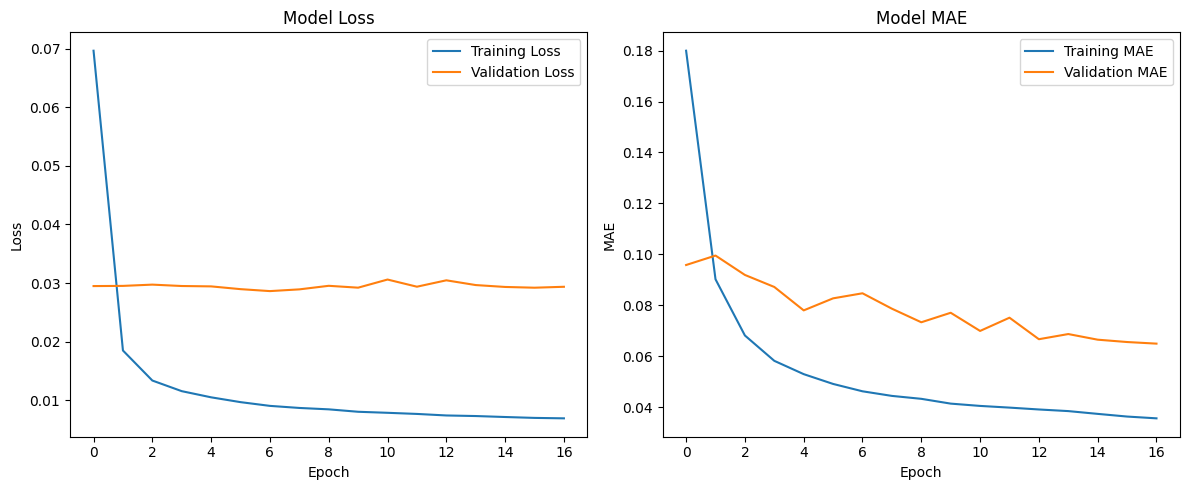

In [83]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history)


In [84]:

# Evaluate the model
print("\nEvaluating model on test data...")
y_test_inv, pred_inv = evaluate_model(lstm_model, X_test, y_test, scaler, output_indices)




Evaluating model on test data...
Test Loss: 0.0377
Test MAE: 0.1082
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step



Plotting predictions vs actual values...


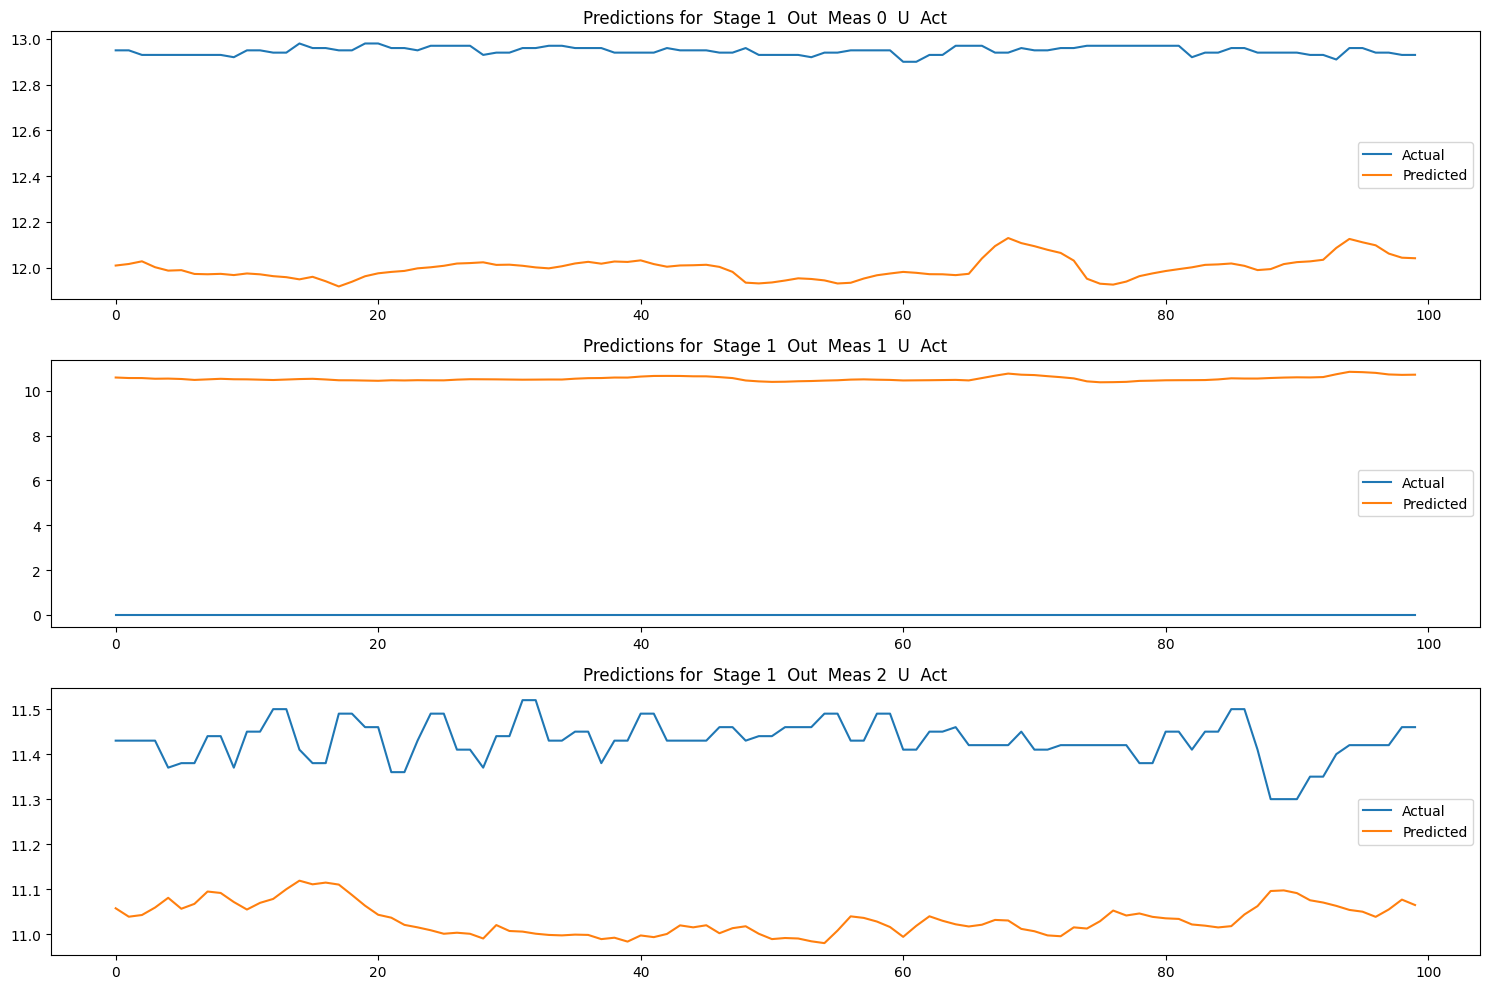

In [85]:
# Plot predictions
print("\nPlotting predictions vs actual values...")
plot_predictions(y_test_inv, pred_inv, output_cols, n_samples=100, n_features=3)


In [86]:

# Calculate RMSE
print("\nCalculating RMSE for each output feature...")
calculate_rmse(y_test_inv, pred_inv, output_cols)

print("\nLSTM model training and evaluation complete!") 


Calculating RMSE for each output feature...
Root Mean Squared Error (RMSE) for each output feature:
 Stage 1  Out  Meas 0  U  Act: 0.8260
 Stage 1  Out  Meas 1  U  Act: 10.7374
 Stage 1  Out  Meas 2  U  Act: 0.3382
 Stage 1  Out  Meas 3  U  Act: 0.7193
 Stage 1  Out  Meas 4  U  Act: 5.1487
 Stage 1  Out  Meas 5  U  Act: 0.5024
 Stage 1  Out  Meas 6  U  Act: 1.1253
 Stage 1  Out  Meas 7  U  Act: 0.2816
 Stage 1  Out  Meas 8  U  Act: 1.3317
 Stage 1  Out  Meas 9  U  Act: 1.2187
 Stage 1  Out  Meas 1 0  U  Act: 0.2042
 Stage 1  Out  Meas 1 1  U  Act: 0.5642
 Stage 1  Out  Meas 1 2  U  Act: 0.0954
 Stage 1  Out  Meas 1 3  U  Act: 0.8411
 Stage 1  Out  Meas 1 4  U  Act: 7.4946
 Stage 2  Out  Meas 0  U  Act: 2.9323
 Stage 2  Out  Meas 1  U  Act: 0.8765
 Stage 2  Out  Meas 2  U  Act: 1.8256
 Stage 2  Out  Meas 3  U  Act: 0.9020
 Stage 2  Out  Meas 4  U  Act: 6.6312
 Stage 2  Out  Meas 5  U  Act: 0.3138
 Stage 2  Out  Meas 6  U  Act: 0.2065
 Stage 2  Out  Meas 7  U  Act: 0.1887
 Stage 2  Out 

In [87]:
def calculate_normalized_errors(y_true, y_pred):
    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Calculate NRMSE (normalized by the range of the true values)
    nrmse_range = rmse / (np.max(y_true) - np.min(y_true))
    
    # Calculate NRMSE (normalized by the mean of the true values)
    nrmse_mean = rmse / np.mean(y_true)
    
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    return {
        'rmse': rmse,
        'nrmse_range': nrmse_range,
        'nrmse_mean': nrmse_mean,
        'mape': mape
    }

In [88]:
y_pred = lstm_model.predict(X_test)  

# For each output feature
normalized_metrics = {}
n_features = y_test.shape[1]  # Get number of features

for i in range(n_features):
    feature_name = f"Feature_{i}"  
    metrics = calculate_normalized_errors(
        y_test[:, i],
        y_pred[:, i]
    )
    normalized_metrics[feature_name] = metrics

# Print results
for feature, metrics in normalized_metrics.items():
    print(f"\nMetrics for {feature}:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"NRMSE (range): {metrics['nrmse_range']:.4f} - Error relative to data range")
    print(f"NRMSE (mean): {metrics['nrmse_mean']:.4f} - Error relative to mean value")
    print(f"MAPE: {metrics['mape']:.2f}% - Average percentage error")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Metrics for Feature_0:
RMSE: 0.0396
NRMSE (range): 1.6856 - Error relative to data range
NRMSE (mean): 0.0640 - Error relative to mean value
MAPE: 6.30% - Average percentage error

Metrics for Feature_1:
RMSE: 0.4821
NRMSE (range): 0.5866 - Error relative to data range
NRMSE (mean): 2.8855 - Error relative to mean value
MAPE: 335.32% - Average percentage error

Metrics for Feature_2:
RMSE: 0.0119
NRMSE (range): 0.0769 - Error relative to data range
NRMSE (mean): 0.0208 - Error relative to mean value
MAPE: 1.57% - Average percentage error

Metrics for Feature_3:
RMSE: 0.0274
NRMSE (range): 1.1989 - Error relative to data range
NRMSE (mean): 0.0334 - Error relative to mean value
MAPE: 3.21% - Average percentage error

Metrics for Feature_4:
RMSE: 0.1483
NRMSE (range): 0.1213 - Error relative to data range
NRMSE (mean): 0.1533 - Error relative to mean value
MAPE: 16828867370.90% - Average percentage error

Metrics for Feature_5:
RMSE: 0.0909
NRMSE (

C:\Users\micha\AppData\Local\Temp\ipykernel_23168\1034542099.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse_range = rmse / (np.max(y_true) - np.min(y_true))


# CycleGAN Time


In [89]:

# Configuration parameters
EPOCHS = 100
BATCH_SIZE = 64
GEN_LEARNING_RATE = 0.0002
DISC_LEARNING_RATE = 0.0002
GEN_HIDDEN_LAYERS = [256, 128, 64]
DISC_HIDDEN_LAYERS = [64, 32, 16]
GEN_DROPOUT_RATE = 0.2
DISC_DROPOUT_RATE = 0.3
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 1.0
VALIDATE_EVERY = 5
SAMPLE_INTERVAL = 5
SAVE_MODEL_INTERVAL = 20


# The Architecture

Here we use list out all of our desired goals of the CycleGAN and give them a space inside out model. We set up the groundwork inside for being able to records it's own history, giving it a long term memory if you will, stealing an idea from above. Next we haev our Generator and Discriminator, but instead we set both of them to be as general as possible allowing for a range of values. This sets us up to be flexible for our gridsearching later!

Now.... as I mentioned above.... it didnt occur to me until building and testing the CycleGAN that the two stages might perform better being seperated and clearly defined. After some research I found that basically having my CycleGAN create and unify two sub-models would help capture this relationship. 

The process of this is by using the data processing function we seperate out the two stages of data. Then CycleGAN takes as input the dimensions of the input features, stage 1 measurements, and stage 2 measurements. It freezes the discriminator models D_S1 and D_S2 during the training of the generator models. This is a common practice in GAN training to stabilize the learning process. It then defines two cycles:

Cycle S1 -> S2 -> S1: It generates fake stage 2 data from input features and stage 1 measurements using the generator G_S1_to_S2. It then passes this fake data to the discriminator D_S2 to get a validity score. Finally, it reconstructs stage 1 data from the fake stage 2 data using the generator G_S2_to_S1.

Cycle S2 -> S1 -> S2: Similar to the first cycle, but starts with stage 2 measurements and generates fake stage 1 data, gets a validity score from D_S1, and reconstructs stage 2 data from the fake stage 1 data.

The cycle consistency loss is calculated by comparing the reconstructed data (reconstructed_stage1 and reconstructed_stage2) with the original input data. The identity loss is calculated by comparing the identity mapped data (identity_stage1 and identity_stage2) with the original input data. These losses help to ensure that the generators not only generate realistic fake data but also preserve the content of the input data during the translation process.

In [90]:


class CycleGAN:
    def __init__(self, 
                 input_dims,
                 stage1_dims=15,  # 15 primary measurements 
                 stage2_dims=15,  # 15 secondary measurements
                 gen_hidden_layers=[256, 128, 64],
                 disc_hidden_layers=[64, 32, 16],
                 gen_dropout_rate=0.2,
                 disc_dropout_rate=0.2,
                 gen_learning_rate=0.0002,
                 disc_learning_rate=0.0002,
                 lambda_cycle=10.0,
                 lambda_identity=1.0):
        
        self.input_dims = input_dims
        self.stage1_dims = stage1_dims
        self.stage2_dims = stage2_dims
        
        self.gen_hidden_layers = gen_hidden_layers
        self.disc_hidden_layers = disc_hidden_layers
        
        self.gen_dropout_rate = gen_dropout_rate
        self.disc_dropout_rate = disc_dropout_rate
        
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        
        # Initialize optimizers
        self.gen_optimizer = Adam(learning_rate=gen_learning_rate, beta_1=0.5)
        self.disc_optimizer = Adam(learning_rate=disc_learning_rate, beta_1=0.5)
        
        # Build the models
        self._build_generators()
        self._build_discriminators()
        self._build_combined_models()
        
        # Initialize history tracking
        self.history = {
            'gen_loss': [],
            'disc_loss': [],
            'cycle_loss': [],
            'identity_loss': [],
            'g_s1_to_s2_loss': [],
            'g_s2_to_s1_loss': [],
            'd_s1_loss': [],
            'd_s2_loss': []
        }

    def _build_generators(self):
        
        # Generator: Input + Stage 1 -> Stage 2
        input_features = Input(shape=(self.input_dims,), name='input_features_s1_to_s2')
        stage1_measurements = Input(shape=(self.stage1_dims,), name='stage1_measurements')
        
        # Concatenate inputs
        x = Concatenate()([input_features, stage1_measurements])
        
        # Build hidden layers
        for i, units in enumerate(self.gen_hidden_layers):
            x = Dense(units, name=f'g_s1_to_s2_dense_{i}')(x)
            x = LeakyReLU(0.2)(x)
            if self.gen_dropout_rate > 0:
                x = Dropout(self.gen_dropout_rate)(x)
        
        # Output layer
        stage2_pred = Dense(self.stage2_dims, activation='linear', name='stage2_predictions')(x)
        
        # Define the model
        self.G_S1_to_S2 = Model([input_features, stage1_measurements], stage2_pred, name='generator_s1_to_s2')
        
        # Generator: Input + Stage 2 -> Stage 1
        input_features = Input(shape=(self.input_dims,), name='input_features_s2_to_s1')
        stage2_measurements = Input(shape=(self.stage2_dims,), name='stage2_measurements')
        
        # Concatenate inputs
        x = Concatenate()([input_features, stage2_measurements])
        
        # Build hidden layers
        for i, units in enumerate(self.gen_hidden_layers):
            x = Dense(units, name=f'g_s2_to_s1_dense_{i}')(x)
            x = LeakyReLU(0.2)(x)
            if self.gen_dropout_rate > 0:
                x = Dropout(self.gen_dropout_rate)(x)
        
        # Output layer
        stage1_pred = Dense(self.stage1_dims, activation='linear', name='stage1_predictions')(x)
        
        # Define the model
        self.G_S2_to_S1 = Model([input_features, stage2_measurements], stage1_pred, name='generator_s2_to_s1')
        
        print("Generator models summary:")
        self.G_S1_to_S2.summary()
        self.G_S2_to_S1.summary()

    def _build_discriminators(self):
        
        # Discriminator for Stage 1 measurements
        input_features = Input(shape=(self.input_dims,), name='input_features_d_s1')
        stage1_measurements = Input(shape=(self.stage1_dims,), name='stage1_measurements_disc')
        
        # Concatenate inputs
        x = Concatenate()([input_features, stage1_measurements])
        
        # Build hidden layers
        for i, units in enumerate(self.disc_hidden_layers):
            x = Dense(units, name=f'd_s1_dense_{i}')(x)
            x = LeakyReLU(0.2)(x)
            if self.disc_dropout_rate > 0:
                x = Dropout(self.disc_dropout_rate)(x)
        
        # Output layer - single neuron with sigmoid for real/fake classification
        validity = Dense(1, activation='sigmoid', name='d_s1_validity')(x)
        
        # Define the model
        self.D_S1 = Model([input_features, stage1_measurements], validity, name='discriminator_s1')
        self.D_S1.compile(loss='binary_crossentropy', optimizer=self.disc_optimizer, metrics=['accuracy'])
        
        # Discriminator for Stage 2 measurements
        input_features = Input(shape=(self.input_dims,), name='input_features_d_s2')
        stage2_measurements = Input(shape=(self.stage2_dims,), name='stage2_measurements_disc')
        
        # Concatenate inputs
        x = Concatenate()([input_features, stage2_measurements])
        
        # Build hidden layers
        for i, units in enumerate(self.disc_hidden_layers):
            x = Dense(units, name=f'd_s2_dense_{i}')(x)
            x = LeakyReLU(0.2)(x)
            if self.disc_dropout_rate > 0:
                x = Dropout(self.disc_dropout_rate)(x)
        
        # Output layer - single neuron with sigmoid for real/fake classification
        validity = Dense(1, activation='sigmoid', name='d_s2_validity')(x)
        
        # Define the model
        self.D_S2 = Model([input_features, stage2_measurements], validity, name='discriminator_s2')
        self.D_S2.compile(loss='binary_crossentropy', optimizer=self.disc_optimizer, metrics=['accuracy'])
        
        print("Discriminator models summary:")
        self.D_S1.summary()
        self.D_S2.summary()

    def _build_combined_models(self):
        
        # Input shapes
        input_features = Input(shape=(self.input_dims,), name='input_features_combined')
        stage1_measurements = Input(shape=(self.stage1_dims,), name='stage1_measurements_combined')
        stage2_measurements = Input(shape=(self.stage2_dims,), name='stage2_measurements_combined')
        
        # Freeze the discriminators during generator training
        self.D_S1.trainable = False
        self.D_S2.trainable = False
        
        # Cycle S1 -> S2 -> S1
        fake_stage2 = self.G_S1_to_S2([input_features, stage1_measurements])
        valid_stage2 = self.D_S2([input_features, fake_stage2])
        reconstructed_stage1 = self.G_S2_to_S1([input_features, fake_stage2])
        
        # Cycle S2 -> S1 -> S2
        fake_stage1 = self.G_S2_to_S1([input_features, stage2_measurements])
        valid_stage1 = self.D_S1([input_features, fake_stage1])
        reconstructed_stage2 = self.G_S1_to_S2([input_features, fake_stage1])
        
        # Identity mapping
        identity_stage1 = self.G_S2_to_S1([input_features, stage1_measurements])
        identity_stage2 = self.G_S1_to_S2([input_features, stage2_measurements])
        
        # Combined model
        self.combined = Model(
            inputs=[input_features, stage1_measurements, stage2_measurements],
            outputs=[
                valid_stage1, valid_stage2,                    
                reconstructed_stage1, reconstructed_stage2,     
                identity_stage1, identity_stage2                
            ],
            name='combined_cyclegan'
        )
        
        # Compile the combined model
        self.combined.compile(
            loss=['binary_crossentropy', 'binary_crossentropy',  
                 'mae', 'mae',                                   
                 'mae', 'mae'],                                 
            loss_weights=[1, 1,                                  
                         self.lambda_cycle, self.lambda_cycle,   # 
                         self.lambda_identity, self.lambda_identity],  
            optimizer=self.gen_optimizer
        )
        
        print("Combined model created")

    def train(self, 
              input_features, 
              stage1_measurements, 
              stage2_measurements,
              epochs=100, 
              batch_size=32, 
              validate_every=10,
              sample_interval=10, 
              save_model_interval=50,
              validation_data=None):
       
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Start training
        for epoch in range(epochs):
            # Get a random batch of samples
            idx = np.random.randint(0, input_features.shape[0], batch_size)
            batch_input = input_features[idx]
            batch_stage1 = stage1_measurements[idx]
            batch_stage2 = stage2_measurements[idx]
            
            # --------------------
            # Train Discriminators
            # --------------------
            
            # Generate fake Stage 2 measurements
            fake_stage2 = self.G_S1_to_S2.predict([batch_input, batch_stage1])
            
            # Train the Stage 2 discriminator
            d_s2_loss_real = self.D_S2.train_on_batch([batch_input, batch_stage2], valid)
            d_s2_loss_fake = self.D_S2.train_on_batch([batch_input, fake_stage2], fake)
            d_s2_loss = 0.5 * np.add(d_s2_loss_real, d_s2_loss_fake)
            
            # Generate fake Stage 1 measurements
            fake_stage1 = self.G_S2_to_S1.predict([batch_input, batch_stage2])
            
            # Train the Stage 1 discriminator
            d_s1_loss_real = self.D_S1.train_on_batch([batch_input, batch_stage1], valid)
            d_s1_loss_fake = self.D_S1.train_on_batch([batch_input, fake_stage1], fake)
            d_s1_loss = 0.5 * np.add(d_s1_loss_real, d_s1_loss_fake)
            
            
            g_loss = self.combined.train_on_batch(
                [batch_input, batch_stage1, batch_stage2],
                [valid, valid,                                      
                 batch_stage1, batch_stage2,                        
                 batch_stage1, batch_stage2]                        
            )
            
            # Store losses
            self.history['disc_loss'].append(0.5 * (d_s1_loss[0] + d_s2_loss[0]))
            self.history['gen_loss'].append(g_loss[0])
            self.history['cycle_loss'].append(g_loss[3] + g_loss[4])
            self.history['identity_loss'].append(g_loss[5] + g_loss[6])
            self.history['g_s1_to_s2_loss'].append(g_loss[1])
            self.history['g_s2_to_s1_loss'].append(g_loss[2])
            self.history['d_s1_loss'].append(d_s1_loss[0])
            self.history['d_s2_loss'].append(d_s2_loss[0])
            
            # Print the progress
            if epoch % sample_interval == 0:
                print(f"Epoch {epoch}/{epochs}")
                print(f"D_S1 Loss: {d_s1_loss[0]:.4f}, Acc: {d_s1_loss[1]:.4f}")
                print(f"D_S2 Loss: {d_s2_loss[0]:.4f}, Acc: {d_s2_loss[1]:.4f}")
                print(f"G Loss: {g_loss[0]:.4f}")
                print(f"Cycle Loss: {g_loss[3] + g_loss[4]:.4f}")
                print(f"Identity Loss: {g_loss[5] + g_loss[6]:.4f}")
                print("-" * 50)
            
            # Validate if requested
            if validation_data is not None and epoch % validate_every == 0:
                self._validate_model(*validation_data)
            
            # Save the model periodically
            if epoch % save_model_interval == 0 and epoch > 0:
                self.save_models(f"cyclegan_epoch_{epoch}")
    
    def _validate_model(self, val_input, val_stage1, val_stage2):
        
        pred_stage2 = self.G_S1_to_S2.predict([val_input, val_stage1])
        pred_stage1 = self.G_S2_to_S1.predict([val_input, val_stage2])
        
        # Calculate MAE
        stage1_mae = np.mean(np.abs(val_stage1 - pred_stage1))
        stage2_mae = np.mean(np.abs(val_stage2 - pred_stage2))
        
        print("Validation Results:")
        print(f"Stage 1 -> Stage 2 MAE: {stage2_mae:.4f}")
        print(f"Stage 2 -> Stage 1 MAE: {stage1_mae:.4f}")
        print("-" * 50)
    
    def predict_stage2(self, input_features, stage1_measurements):
        
        return self.G_S1_to_S2.predict([input_features, stage1_measurements])
    
    def predict_stage1(self, input_features, stage2_measurements):
        
        return self.G_S2_to_S1.predict([input_features, stage2_measurements])
    
    def save_models(self, model_name_prefix="cyclegan"):
        
        self.G_S1_to_S2.save(f"{model_name_prefix}_g_s1_to_s2.keras")
        self.G_S2_to_S1.save(f"{model_name_prefix}_g_s2_to_s1.keras")
        self.D_S1.save(f"{model_name_prefix}_d_s1.keras")
        self.D_S2.save(f"{model_name_prefix}_d_s2.keras")
        
        
        self.combined.save_weights(f"{model_name_prefix}_combined.weights.h5")
        
        # Save history
        np.save(f"{model_name_prefix}_history.npy", self.history)
        
    def load_models(self, model_name_prefix="cyclegan"):
        
        self.G_S1_to_S2 = tf.keras.models.load_model(f"{model_name_prefix}_g_s1_to_s2.keras")
        self.G_S2_to_S1 = tf.keras.models.load_model(f"{model_name_prefix}_g_s2_to_s1.keras")
        self.D_S1 = tf.keras.models.load_model(f"{model_name_prefix}_d_s1.keras")
        self.D_S2 = tf.keras.models.load_model(f"{model_name_prefix}_d_s2.keras")
        
        # Rebuild and load weights for the combined model
        self._build_combined_models()
       
        self.combined.load_weights(f"{model_name_prefix}_combined.weights.h5")
        
        # Load history
        try:
            self.history = np.load(f"{model_name_prefix}_history.npy", allow_pickle=True).item()
        except:
            print("Could not load training history")
    
    def plot_history(self):
        
        plt.figure(figsize=(15, 10))
        
        # Plot generator and discriminator losses
        plt.subplot(2, 2, 1)
        plt.plot(self.history['gen_loss'], label='Generator Loss')
        plt.plot(self.history['disc_loss'], label='Discriminator Loss')
        plt.title('Generator and Discriminator Loss')
        plt.legend()
        
        # Plot cycle and identity losses
        plt.subplot(2, 2, 2)
        plt.plot(self.history['cycle_loss'], label='Cycle Loss')
        plt.plot(self.history['identity_loss'], label='Identity Loss')
        plt.title('Cycle and Identity Losses')
        plt.legend()
        
        # Plot individual generator losses
        plt.subplot(2, 2, 3)
        plt.plot(self.history['g_s1_to_s2_loss'], label='G: S1 -> S2')
        plt.plot(self.history['g_s2_to_s1_loss'], label='G: S2 -> S1')
        plt.title('Generator Losses by Direction')
        plt.legend()
        
        # Plot individual discriminator losses
        plt.subplot(2, 2, 4)
        plt.plot(self.history['d_s1_loss'], label='D: S1')
        plt.plot(self.history['d_s2_loss'], label='D: S2')
        plt.title('Discriminator Losses')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('cyclegan_training_history.png')
        plt.show()
        
    def evaluate_model(self, input_features, stage1_measurements, stage2_measurements):
       
        pred_stage2 = self.predict_stage2(input_features, stage1_measurements)
        pred_stage1 = self.predict_stage1(input_features, stage2_measurements)
        
        
        stage1_mae = np.mean(np.abs(stage1_measurements - pred_stage1))
        stage2_mae = np.mean(np.abs(stage2_measurements - pred_stage2))
        
        stage1_mse = np.mean(np.square(stage1_measurements - pred_stage1))
        stage2_mse = np.mean(np.square(stage2_measurements - pred_stage2))
        
        # Calculate cycle consistency
        reconstructed_stage1 = self.predict_stage1(input_features, pred_stage2)
        reconstructed_stage2 = self.predict_stage2(input_features, pred_stage1)
        
        cycle_s1_mae = np.mean(np.abs(stage1_measurements - reconstructed_stage1))
        cycle_s2_mae = np.mean(np.abs(stage2_measurements - reconstructed_stage2))
        
        # Return metrics
        return {
            'stage1_mae': stage1_mae,
            'stage2_mae': stage2_mae,
            'stage1_mse': stage1_mse,
            'stage2_mse': stage2_mse,
            'cycle_s1_mae': cycle_s1_mae,
            'cycle_s2_mae': cycle_s2_mae
        }

# Scale and Normalize

This is a function to scale and normalize data. I made this before I had the idea of just doing this once in the beginning and saving the new dataframe. LEssons learned. 

In [91]:

# Utility functions for data preprocessing
def preprocess_data(df, stage1_cols, stage2_cols, input_cols=None):
    
    if input_cols is None:
        all_stage_cols = stage1_cols + stage2_cols
        input_cols = [col for col in df.columns if col not in all_stage_cols]
    
    # Extract data
    X = df[input_cols].values
    stage1_data = df[stage1_cols].values
    stage2_data = df[stage2_cols].values
    
    # Create scalers
    x_scaler = StandardScaler()
    stage1_scaler = StandardScaler()
    stage2_scaler = StandardScaler()
    
    # Fit and transform
    X_scaled = x_scaler.fit_transform(X)
    stage1_scaled = stage1_scaler.fit_transform(stage1_data)
    stage2_scaled = stage2_scaler.fit_transform(stage2_data)
    
    scalers = {
        'input': x_scaler,
        'stage1': stage1_scaler,
        'stage2': stage2_scaler
    }
    
    return X_scaled, stage1_scaled, stage2_scaled, scalers


# Data Split

Here we split the normalized and scaled data. Again, since we have no testing data we have to split off a chunk for that.

In [92]:

def train_test_validation_split(X, stage1, stage2, test_size=0.15, val_size=0.15, random_state=42):
    
    # First split: separate test set
    X_temp, X_test, stage1_temp, stage1_test, stage2_temp, stage2_test = train_test_split(
        X, stage1, stage2, test_size=test_size, random_state=random_state
    )
    
    # Second split: separate validation set from temporary training set
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, stage1_train, stage1_val, stage2_train, stage2_val = train_test_split(
        X_temp, stage1_temp, stage2_temp, test_size=val_ratio, random_state=random_state
    )
    
    return (X_train, stage1_train, stage2_train, 
            X_val, stage1_val, stage2_val, 
            X_test, stage1_test, stage2_test) 

In [105]:

def load_and_prepare_data(file_path='continuous_factory_process.csv'):
    
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    
    # Extract Stage 1 (primary output) measurement columns
    stage1_actual_cols = [col for col in df.columns if 'Stage1.Output.Measurement' in col and '.U.Actual' in col]
    
    # Extract Stage 2 (secondary output) measurement columns
    stage2_actual_cols = [col for col in df.columns if 'Stage2.Output.Measurement' in col and '.U.Actual' in col]
    
    
    input_cols = [col for col in df.columns if col not in stage1_actual_cols + stage2_actual_cols and col != 'time_stamp']
    
    print(f"Using {len(input_cols)} columns as input features")
    
    # Preprocess the data
    X_scaled, stage1_scaled, stage2_scaled, scalers = preprocess_data(
        df, stage1_actual_cols, stage2_actual_cols, input_cols
    )
    
    print("Data preprocessing complete")
    print(f"Input shape: {X_scaled.shape}")
    print(f"Stage 1 shape: {stage1_scaled.shape}")
    print(f"Stage 2 shape: {stage2_scaled.shape}")
    
    # Split into train, validation, and test sets
    data_splits = train_test_validation_split(
        X_scaled, stage1_scaled, stage2_scaled, 
        test_size=0.15, 
        val_size=0.15
    )
    
    # Save column information for later use
    column_info = {
        'input_cols': input_cols,
        'stage1_cols': stage1_actual_cols,
        'stage2_cols': stage2_actual_cols
    }
    
    with open('column_info.json', 'w') as f:
        json.dump(column_info, f)
    
    print("Data split complete")
    print(f"Train set size: {data_splits[0].shape[0]}")
    print(f"Validation set size: {data_splits[3].shape[0]}")
    print(f"Test set size: {data_splits[6].shape[0]}")
    
    return data_splits + (scalers,)


# Look for and Load pre-existing models

Here I wanted to be able to load models Ive already trained. This is a crucial step for grid searching and parameter tuning I believe. Being able to recall my work, especially with CycleGANS, makes the fine tuning process infinitely easier.

In [94]:
def load_model_and_data(model_dir='models', 
                       model_name='cyclegan_final',
                       data_path='continuous_factory_process.csv',
                       column_info_path='column_info.json'):
    
    with open(column_info_path, 'r') as f:
        column_info = json.load(f)
    
    # Load original data
    df = pd.read_csv(data_path)
    
    # Get column lists
    input_cols = column_info['input_cols']
    stage1_cols = column_info['stage1_cols']
    stage2_cols = column_info['stage2_cols']
    
    # Preprocess data
    X_scaled, stage1_scaled, stage2_scaled, scalers = preprocess_data(
        df, stage1_cols, stage2_cols, input_cols
    )
    
    # Create a test set (using the last 15% of data)
    test_size = int(0.15 * X_scaled.shape[0])
    X_test = X_scaled[-test_size:]
    stage1_test = stage1_scaled[-test_size:]
    stage2_test = stage2_scaled[-test_size:]
    
    # Also get the original (unscaled) data for better visualization
    X_test_orig = df[input_cols].values[-test_size:]
    stage1_test_orig = df[stage1_cols].values[-test_size:]
    stage2_test_orig = df[stage2_cols].values[-test_size:]
    
    # Create a dummy initialization to reconstruct the model
    input_dims = X_scaled.shape[1]
    stage1_dims = stage1_scaled.shape[1]
    stage2_dims = stage2_scaled.shape[1]
    
    dummy_model = CycleGAN(
        input_dims=input_dims,
        stage1_dims=stage1_dims,
        stage2_dims=stage2_dims
    )
    
    # Load the trained weights
    model_path = os.path.join(model_dir, model_name)
    dummy_model.load_models(model_path)
    
    # Prepare test data dictionary
    test_data = {
        'X_test': X_test,
        'stage1_test': stage1_test,
        'stage2_test': stage2_test,
        'X_test_orig': X_test_orig,
        'stage1_test_orig': stage1_test_orig,
        'stage2_test_orig': stage2_test_orig,
        'scalers': scalers,
        'column_info': column_info
    }
    
    return dummy_model, test_data


In [95]:

def generate_predictions(model, test_data):
    
    # Generate predictions
    pred_stage2 = model.predict_stage2(test_data['X_test'], test_data['stage1_test'])
    pred_stage1 = model.predict_stage1(test_data['X_test'], test_data['stage2_test'])
    
    # Generate cycle reconstructions
    cycle_stage1 = model.predict_stage1(test_data['X_test'], pred_stage2)
    cycle_stage2 = model.predict_stage2(test_data['X_test'], pred_stage1)
    
    # Inverse transform predictions to original scale
    stage1_scaler = test_data['scalers']['stage1']
    stage2_scaler = test_data['scalers']['stage2']
    
    pred_stage1_orig = stage1_scaler.inverse_transform(pred_stage1)
    pred_stage2_orig = stage2_scaler.inverse_transform(pred_stage2)
    cycle_stage1_orig = stage1_scaler.inverse_transform(cycle_stage1)
    cycle_stage2_orig = stage2_scaler.inverse_transform(cycle_stage2)
    
    # Assemble results
    predictions = {
        'pred_stage1': pred_stage1,
        'pred_stage2': pred_stage2,
        'cycle_stage1': cycle_stage1,
        'cycle_stage2': cycle_stage2,
        'pred_stage1_orig': pred_stage1_orig,
        'pred_stage2_orig': pred_stage2_orig,
        'cycle_stage1_orig': cycle_stage1_orig,
        'cycle_stage2_orig': cycle_stage2_orig
    }
    
    return predictions



In [96]:

def calculate_metrics(test_data, predictions):
    
    # Calculate metrics in scaled space
    stage1_mae = mean_absolute_error(test_data['stage1_test'], predictions['pred_stage1'])
    stage2_mae = mean_absolute_error(test_data['stage2_test'], predictions['pred_stage2'])
    
    stage1_mse = mean_squared_error(test_data['stage1_test'], predictions['pred_stage1'])
    stage2_mse = mean_squared_error(test_data['stage2_test'], predictions['pred_stage2'])
    
    cycle_s1_mae = mean_absolute_error(test_data['stage1_test'], predictions['cycle_stage1'])
    cycle_s2_mae = mean_absolute_error(test_data['stage2_test'], predictions['cycle_stage2'])
    
    # Calculate metrics in original space
    stage1_mae_orig = mean_absolute_error(test_data['stage1_test_orig'], predictions['pred_stage1_orig'])
    stage2_mae_orig = mean_absolute_error(test_data['stage2_test_orig'], predictions['pred_stage2_orig'])
    
    stage1_mse_orig = mean_squared_error(test_data['stage1_test_orig'], predictions['pred_stage1_orig'])
    stage2_mse_orig = mean_squared_error(test_data['stage2_test_orig'], predictions['pred_stage2_orig'])
    
    # Calculate R² scores for each measurement
    r2_stage1 = []
    r2_stage2 = []
    
    for i in range(test_data['stage1_test_orig'].shape[1]):
        r2_stage1.append(r2_score(test_data['stage1_test_orig'][:, i], predictions['pred_stage1_orig'][:, i]))
    
    for i in range(test_data['stage2_test_orig'].shape[1]):
        r2_stage2.append(r2_score(test_data['stage2_test_orig'][:, i], predictions['pred_stage2_orig'][:, i]))
    
    # Compile metrics
    metrics = {
        'stage1_mae': stage1_mae,
        'stage2_mae': stage2_mae,
        'stage1_mse': stage1_mse,
        'stage2_mse': stage2_mse,
        'cycle_s1_mae': cycle_s1_mae,
        'cycle_s2_mae': cycle_s2_mae,
        'stage1_mae_orig': stage1_mae_orig,
        'stage2_mae_orig': stage2_mae_orig,
        'stage1_mse_orig': stage1_mse_orig,
        'stage2_mse_orig': stage2_mse_orig,
        'r2_stage1': r2_stage1,
        'r2_stage2': r2_stage2,
        'avg_r2_stage1': np.mean(r2_stage1),
        'avg_r2_stage2': np.mean(r2_stage2)
    }
    
    return metrics



# Visualization Helpers

Here I wanted to make some methods to help plot my evaluations. I wanted to be able to see the relationships between the stages, but also the performance of the models during the grid search. 

In [97]:

def plot_predictions(test_data, predictions, sample_indices=None, num_samples=3):
    
    if sample_indices is None:
        # Choose random samples
        sample_indices = np.random.choice(len(test_data['stage1_test']), num_samples, replace=False)
    
    # Create a directory for plots
    os.makedirs('plots', exist_ok=True)
    
    # Get column names
    stage1_cols = test_data['column_info']['stage1_cols']
    stage2_cols = test_data['column_info']['stage2_cols']
    
    
    stage1_names = [col.replace('Stage1.Output.Measurement', 'S1.Meas').replace('.U.Actual', '') 
                   for col in stage1_cols]
    stage2_names = [col.replace('Stage2.Output.Measurement', 'S2.Meas').replace('.U.Actual', '') 
                   for col in stage2_cols]
    
    # Plot predictions for each sample
    for i, idx in enumerate(sample_indices):
        fig, axes = plt.subplots(2, 1, figsize=(15, 12))
        
        # Stage 1 measurements
        ax = axes[0]
        ax.set_title(f'Sample {i+1}: Stage 1 Measurements (Primary Output)')
        
        # Ground truth
        ax.plot(stage1_names, test_data['stage1_test_orig'][idx], 'o-', label='Ground Truth')
        
        # Prediction
        ax.plot(stage1_names, predictions['pred_stage1_orig'][idx], 's--', label='Predicted')
        
        # Cycle reconstruction
        ax.plot(stage1_names, predictions['cycle_stage1_orig'][idx], '^:', label='Cycle Reconstruction')
        
        ax.set_xticks(range(len(stage1_names)))
        ax.set_xticklabels(stage1_names, rotation=45)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Stage 2 measurements
        ax = axes[1]
        ax.set_title(f'Sample {i+1}: Stage 2 Measurements (Secondary Output)')
        
        # Ground truth
        ax.plot(stage2_names, test_data['stage2_test_orig'][idx], 'o-', label='Ground Truth')
        
        # Prediction
        ax.plot(stage2_names, predictions['pred_stage2_orig'][idx], 's--', label='Predicted')
        
        # Cycle reconstruction
        ax.plot(stage2_names, predictions['cycle_stage2_orig'][idx], '^:', label='Cycle Reconstruction')
        
        ax.set_xticks(range(len(stage2_names)))
        ax.set_xticklabels(stage2_names, rotation=45)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(f'plots/sample_{i+1}_predictions.png')
        plt.close()
    
    
    metrics = calculate_metrics(test_data, predictions)
    
    plt.figure(figsize=(14, 6))
    
    # Stage 1 
    plt.subplot(1, 2, 1)
    plt.bar(stage1_names, metrics['r2_stage1'])
    plt.title('R² Scores for Stage 1 Measurements')
    plt.xticks(rotation=45)
    plt.ylim([-0.5, 1.0])
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.bar(stage2_names, metrics['r2_stage2'])
    plt.title('R² Scores for Stage 2 Measurements')
    plt.xticks(rotation=45)
    plt.ylim([-0.5, 1.0])
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/r2_scores.png')
    plt.close()
    
    # Plot error distributions
    plt.figure(figsize=(14, 6))
    
    # Stage 1 errors
    errors_stage1 = test_data['stage1_test_orig'] - predictions['pred_stage1_orig']
    plt.subplot(1, 2, 1)
    plt.boxplot(errors_stage1, labels=stage1_names)
    plt.title('Error Distribution for Stage 1 Measurements')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Stage 2 errors
    errors_stage2 = test_data['stage2_test_orig'] - predictions['pred_stage2_orig']
    plt.subplot(1, 2, 2)
    plt.boxplot(errors_stage2, labels=stage2_names)
    plt.title('Error Distribution for Stage 2 Measurements')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/error_distributions.png')
    plt.close()

In [98]:

def plot_time_series(test_data, predictions, num_samples=200, measurement_indices=None):
    
    if measurement_indices is None:
        # Use a set of 3 measurements for each stage as representative examples
        stage1_indices = [0, 7, 14]  # First, middle, last measurement
        stage2_indices = [0, 7, 14]  # First, middle, last measurement
    else:
        stage1_indices = measurement_indices
        stage2_indices = measurement_indices
    
    # Create a directory for plots
    os.makedirs('plots', exist_ok=True)
    
    # Get column names
    stage1_cols = test_data['column_info']['stage1_cols']
    stage2_cols = test_data['column_info']['stage2_cols']
    
    # Select a continuous segment of the test data
    start_idx = 0
    end_idx = min(start_idx + num_samples, len(test_data['stage1_test']))
    
    
    time_indices = np.arange(end_idx - start_idx)
    
    # Plot Stage 1 time series
    plt.figure(figsize=(15, 12))
    for i, idx in enumerate(stage1_indices):
        plt.subplot(3, 1, i+1)
        
        
        plt.plot(time_indices, test_data['stage1_test_orig'][start_idx:end_idx, idx], 
                'b-', label='Ground Truth')
        
        
        plt.plot(time_indices, predictions['pred_stage1_orig'][start_idx:end_idx, idx], 
                'r--', label='Predicted')
        
        # Get measurement name
        meas_name = stage1_cols[idx].replace('Stage1.Output.Measurement', 'Meas').replace('.U.Actual', '')
        plt.title(f'Stage 1 - {meas_name} Time Series')
        plt.xlabel('Time Step')
        plt.ylabel('Measurement Value')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('plots/stage1_time_series.png')
    plt.close()
    
    # Plot Stage 2 time series
    plt.figure(figsize=(15, 12))
    for i, idx in enumerate(stage2_indices):
        plt.subplot(3, 1, i+1)
        
        # Ground truth
        plt.plot(time_indices, test_data['stage2_test_orig'][start_idx:end_idx, idx], 
                'b-', label='Ground Truth')
        
        # Prediction
        plt.plot(time_indices, predictions['pred_stage2_orig'][start_idx:end_idx, idx], 
                'r--', label='Predicted')
        
        # Get measurement name
        meas_name = stage2_cols[idx].replace('Stage2.Output.Measurement', 'Meas').replace('.U.Actual', '')
        plt.title(f'Stage 2 - {meas_name} Time Series')
        plt.xlabel('Time Step')
        plt.ylabel('Measurement Value')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('plots/stage2_time_series.png')
    plt.close()

In [99]:

def evaluate_and_visualize(model_dir='models', model_name='cyclegan_final'):
    
    print(f"Loading model from {model_dir}/{model_name}...")
    model, test_data = load_model_and_data(model_dir, model_name)
    
    print("Generating predictions...")
    predictions = generate_predictions(model, test_data)
    
    print("Calculating metrics...")
    metrics = calculate_metrics(test_data, predictions)
    
    # Save metrics
    with open(f'{model_dir}/evaluation_metrics.json', 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        metrics_json = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in metrics.items()}
        json.dump(metrics_json, f, indent=2)
    
    # Print summary metrics
    print("\nEvaluation Metrics:")
    print(f"Stage 1 MAE: {metrics['stage1_mae_orig']:.4f}")
    print(f"Stage 2 MAE: {metrics['stage2_mae_orig']:.4f}")
    print(f"Stage 1 Average R²: {metrics['avg_r2_stage1']:.4f}")
    print(f"Stage 2 Average R²: {metrics['avg_r2_stage2']:.4f}")
    print(f"Cycle Consistency Stage 1 MAE: {metrics['cycle_s1_mae']:.4f}")
    print(f"Cycle Consistency Stage 2 MAE: {metrics['cycle_s2_mae']:.4f}")
    
    print("\nCreating visualization plots...")
    
    # Plot sample predictions
    print("Plotting sample predictions...")
    plot_predictions(test_data, predictions, num_samples=5)
    
    # Plot time series
    print("Plotting time series...")
    plot_time_series(test_data, predictions, num_samples=200)
    
    print(f"Evaluation complete. Visualizations saved to the 'plots' directory.")

if __name__ == "__main__":
    
    evaluate_and_visualize(model_dir='models', model_name='cyclegan_final') 

Loading model from models/cyclegan_final...
Generator models summary:


Model: "generator_s1_to_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s1_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_0  │ (None, 256)       │     25,856 │ concatenate_8[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_24      │ (None, 256)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 256)       │          0 │ leaky_re_lu_24[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_1  │ (None, 128)       │     32,896 │ dropout_26[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_25      │ (None, 128)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 128)       │          0 │ leaky_re_lu_25[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_2  │ (None, 64)        │      8,256 │ dropout_27[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_26      │ (None, 64)        │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ leaky_re_lu_26[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_predictions  │ (None, 15)        │        975 │ dropout_28[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,983 (265.56 KB)

 Trainable params: 67,983 (265.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_s2_to_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s2_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_0  │ (None, 256)       │     25,856 │ concatenate_9[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_27      │ (None, 256)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 256)       │          0 │ leaky_re_lu_27[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_1  │ (None, 128)       │     32,896 │ dropout_29[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_28      │ (None, 128)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 128)       │          0 │ leaky_re_lu_28[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_2  │ (None, 64)        │      8,256 │ dropout_30[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_29      │ (None, 64)        │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 64)        │          0 │ leaky_re_lu_29[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_predictions  │ (None, 15)        │        975 │ dropout_31[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,983 (265.56 KB)

 Trainable params: 67,983 (265.56 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator models summary:


Model: "discriminator_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s1 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_0        │ (None, 64)        │      6,464 │ concatenate_10[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_30      │ (None, 64)        │          0 │ d_s1_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 64)        │          0 │ leaky_re_lu_30[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_1        │ (None, 32)        │      2,080 │ dropout_32[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_31      │ (None, 32)        │          0 │ d_s1_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 32)        │          0 │ leaky_re_lu_31[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_2        │ (None, 16)        │        528 │ dropout_33[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_32      │ (None, 16)        │          0 │ d_s1_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 16)        │          0 │ leaky_re_lu_32[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_validity       │ (None, 1)         │         17 │ dropout_34[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s2 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_0        │ (None, 64)        │      6,464 │ concatenate_11[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_33      │ (None, 64)        │          0 │ d_s2_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 64)        │          0 │ leaky_re_lu_33[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_1        │ (None, 32)        │      2,080 │ dropout_35[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_34      │ (None, 32)        │          0 │ d_s2_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 32)        │          0 │ leaky_re_lu_34[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_2        │ (None, 16)        │        528 │ dropout_36[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_35      │ (None, 16)        │          0 │ d_s2_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 16)        │          0 │ leaky_re_lu_35[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_validity       │ (None, 1)         │         17 │ dropout_37[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Combined model created
Combined model created
Generating predictions...
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\micha\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\micha\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
Calculating metrics...

Evaluation Metrics:
Stage 1 MAE: 0.8207
Stage 2 MAE: 1.0449
Stage 1 Average R²: -19.0364
Stage 2 Average R²: -1.5261
Cycle Consistency Stage 1 MAE: 0.2225
Cycle Consistency Stage 2 MAE: 0.2563

Creating visualization plots...
Plotting sample predictions...


C:\Users\micha\AppData\Local\Temp\ipykernel_23168\3636128055.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors_stage1, labels=stage1_names)
C:\Users\micha\AppData\Local\Temp\ipykernel_23168\3636128055.py:102: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors_stage2, labels=stage2_names)


Plotting time series...
Evaluation complete. Visualizations saved to the 'plots' directory.


# CycleGAN Training

So here we start by logging our hyperparameters, use our helper functions to create the model with our architecture, and apply the training data!

In [100]:

def train_cyclegan(data_splits, input_dims, hyperparameters=None):

    
    X_train, stage1_train, stage2_train, X_val, stage1_val, stage2_val, X_test, stage1_test, stage2_test = data_splits
    
    
    params = {
        'gen_hidden_layers': GEN_HIDDEN_LAYERS,
        'disc_hidden_layers': DISC_HIDDEN_LAYERS,
        'gen_dropout_rate': GEN_DROPOUT_RATE,
        'disc_dropout_rate': DISC_DROPOUT_RATE,
        'gen_learning_rate': GEN_LEARNING_RATE,
        'disc_learning_rate': DISC_LEARNING_RATE,
        'lambda_cycle': LAMBDA_CYCLE,
        'lambda_identity': LAMBDA_IDENTITY
    }
    
    if hyperparameters:
        params.update(hyperparameters)
    
    # Log the hyperparameters
    print("Training with hyperparameters:")
    for k, v in params.items():
        print(f"- {k}: {v}")
    
    # Create the model
    model = CycleGAN(
        input_dims=input_dims,
        stage1_dims=stage1_train.shape[1],
        stage2_dims=stage2_train.shape[1],
        **params
    )
    
    # Create a model directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Train the model
    print(f"Starting training for {EPOCHS} epochs with batch size {BATCH_SIZE}...")
    model.train(
        input_features=X_train,
        stage1_measurements=stage1_train,
        stage2_measurements=stage2_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validate_every=VALIDATE_EVERY,
        sample_interval=SAMPLE_INTERVAL,
        save_model_interval=SAVE_MODEL_INTERVAL,
        validation_data=(X_val, stage1_val, stage2_val)
    )
    
    # Save the final model
    model.save_models('models/cyclegan_final')
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_metrics = model.evaluate_model(X_test, stage1_test, stage2_test)
    
    
    print("Test set metrics:")
    for metric, value in test_metrics.items():
        print(f"- {metric}: {value:.4f}")
    
    with open('models/test_metrics.json', 'w') as f:
        json.dump(test_metrics, f)
    
    # Plot training history
    model.plot_history()
    
    return model


# CycleGAN Hyperparameter tuning

Here we leverage our grid and map out our set of parameters we want to iterate through. We employ our helper functions above for loading in teh data ( This ensures the data is scaled and split appropriatly) and the evaluate model funciton. Both of these combined help create the grid and find the best parameters. 

Loading data from continuous_factory_process.csv...
Using 85 columns as input features
Data preprocessing complete
Input shape: (14088, 85)
Stage 1 shape: (14088, 15)
Stage 2 shape: (14088, 15)
Data split complete
Train set size: 9860
Validation set size: 2114
Test set size: 2114
Training CycleGAN with default hyperparameters...
Training with hyperparameters:
- gen_hidden_layers: [256, 128, 64]
- disc_hidden_layers: [64, 32, 16]
- gen_dropout_rate: 0.2
- disc_dropout_rate: 0.3
- gen_learning_rate: 0.0002
- disc_learning_rate: 0.0002
- lambda_cycle: 10.0
- lambda_identity: 1.0
Generator models summary:


Model: "generator_s1_to_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s1_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_0  │ (None, 256)       │     25,856 │ concatenate_12[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_36      │ (None, 256)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 256)       │          0 │ leaky_re_lu_36[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_1  │ (None, 128)       │     32,896 │ dropout_38[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_37      │ (None, 128)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 128)       │          0 │ leaky_re_lu_37[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_2  │ (None, 64)        │      8,256 │ dropout_39[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_38      │ (None, 64)        │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 64)        │          0 │ leaky_re_lu_38[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_predictions  │ (None, 15)        │        975 │ dropout_40[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,983 (265.56 KB)

 Trainable params: 67,983 (265.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_s2_to_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s2_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_0  │ (None, 256)       │     25,856 │ concatenate_13[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_39      │ (None, 256)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 256)       │          0 │ leaky_re_lu_39[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_1  │ (None, 128)       │     32,896 │ dropout_41[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_40      │ (None, 128)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 128)       │          0 │ leaky_re_lu_40[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_2  │ (None, 64)        │      8,256 │ dropout_42[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_41      │ (None, 64)        │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 64)        │          0 │ leaky_re_lu_41[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_predictions  │ (None, 15)        │        975 │ dropout_43[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,983 (265.56 KB)

 Trainable params: 67,983 (265.56 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator models summary:


Model: "discriminator_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s1 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_0        │ (None, 64)        │      6,464 │ concatenate_14[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_42      │ (None, 64)        │          0 │ d_s1_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 64)        │          0 │ leaky_re_lu_42[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_1        │ (None, 32)        │      2,080 │ dropout_44[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_43      │ (None, 32)        │          0 │ d_s1_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 32)        │          0 │ leaky_re_lu_43[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_2        │ (None, 16)        │        528 │ dropout_45[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_44      │ (None, 16)        │          0 │ d_s1_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 16)        │          0 │ leaky_re_lu_44[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_validity       │ (None, 1)         │         17 │ dropout_46[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s2 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_0        │ (None, 64)        │      6,464 │ concatenate_15[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_45      │ (None, 64)        │          0 │ d_s2_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 64)        │          0 │ leaky_re_lu_45[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_1        │ (None, 32)        │      2,080 │ dropout_47[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_46      │ (None, 32)        │          0 │ d_s2_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 32)        │          0 │ leaky_re_lu_46[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_2        │ (None, 16)        │        528 │ dropout_48[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_47      │ (None, 16)        │          0 │ d_s2_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 16)        │          0 │ leaky_re_lu_47[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_validity       │ (None, 1)         │         17 │ dropout_49[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Combined model created
Starting training for 100 epochs with batch size 64...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\micha\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
Epoch 0/100
D_S1 Loss: 0.8351, Acc: 0.4531
D_S2 Loss: 0.7938, Acc: 0.4609
G Loss: 16.7066
Cycle Loss: 1.3582
Identity Loss: 1.3582
--------------------------------------------------
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Results:
Stage 1 -> Stage 2 MAE: 0.6201
Stage 2 -> Stage 1 MAE: 0.6544
--------------------------------------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 5/100
D_S1 Loss: 0.7796, Acc: 0.4691
D_S2 Loss: 0.7795, Acc: 0.4771
G Loss: 15.8721
Cycle Loss: 1.3232
Identity Loss: 1.3232
--------------------------------------------------
67/67 

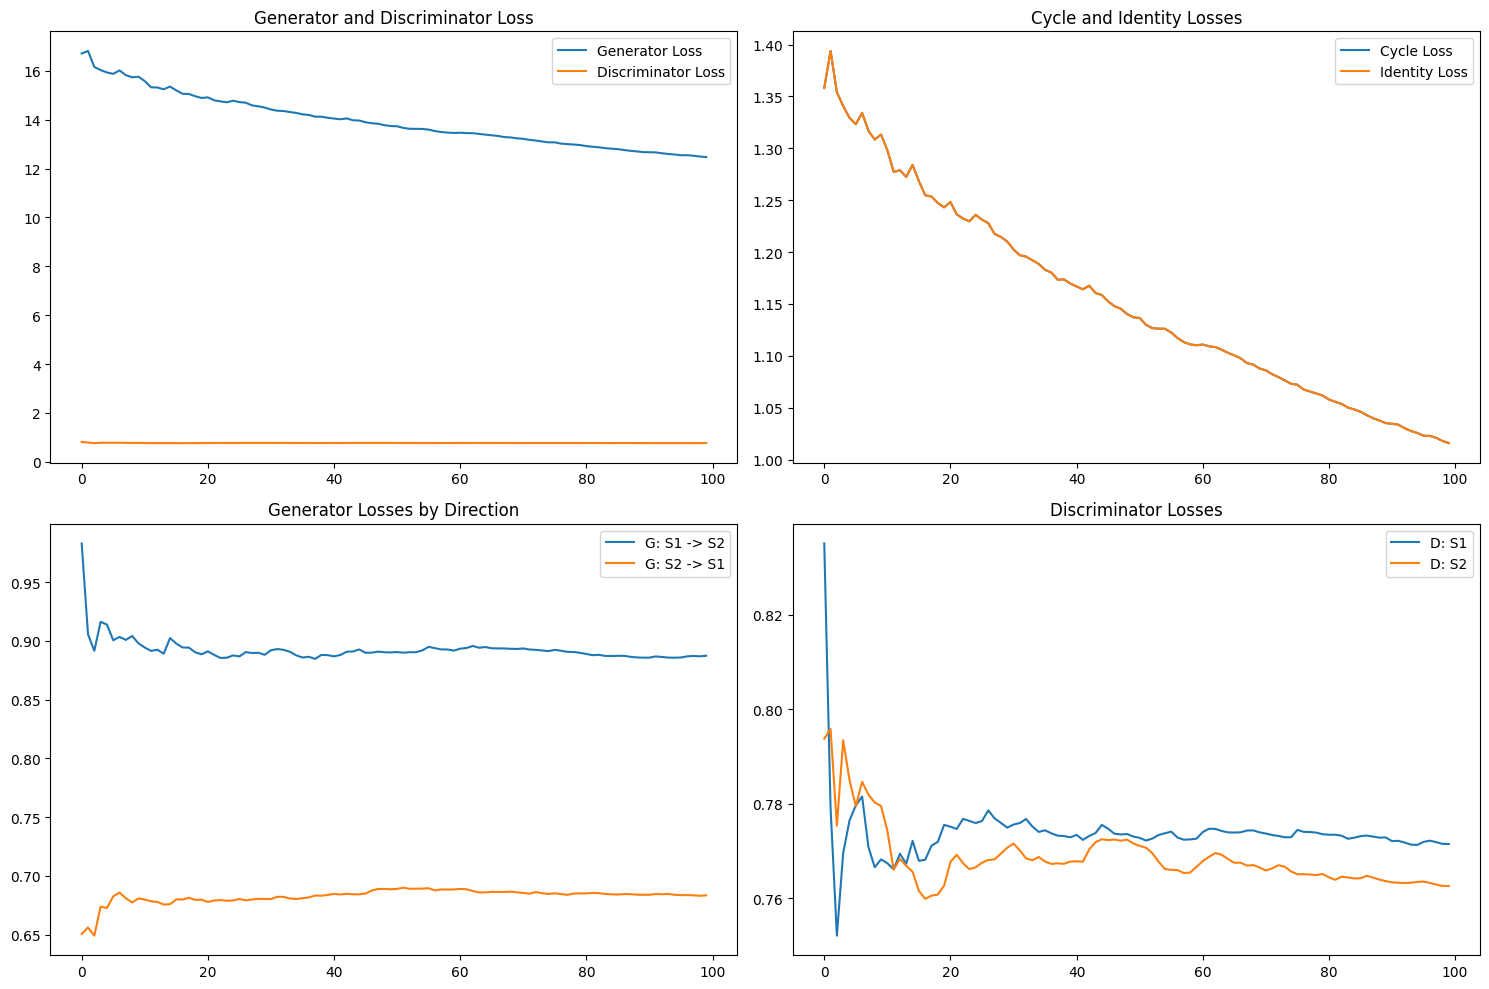

Starting hyperparameter tuning...
Tuning configuration 1/3
Parameters: {'gen_hidden_layers': [256, 128, 64], 'disc_hidden_layers': [64, 32, 16], 'gen_dropout_rate': 0.2, 'disc_dropout_rate': 0.3, 'gen_learning_rate': 0.0002, 'disc_learning_rate': 0.0002, 'lambda_cycle': 10.0, 'lambda_identity': 1.0}
Generator models summary:


Model: "generator_s1_to_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s1_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_0  │ (None, 256)       │     25,856 │ concatenate_16[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_48      │ (None, 256)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 256)       │          0 │ leaky_re_lu_48[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_1  │ (None, 128)       │     32,896 │ dropout_50[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_49      │ (None, 128)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 128)       │          0 │ leaky_re_lu_49[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_2  │ (None, 64)        │      8,256 │ dropout_51[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_50      │ (None, 64)        │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 64)        │          0 │ leaky_re_lu_50[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_predictions  │ (None, 15)        │        975 │ dropout_52[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,983 (265.56 KB)

 Trainable params: 67,983 (265.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_s2_to_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s2_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_0  │ (None, 256)       │     25,856 │ concatenate_17[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_51      │ (None, 256)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 256)       │          0 │ leaky_re_lu_51[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_1  │ (None, 128)       │     32,896 │ dropout_53[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_52      │ (None, 128)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 128)       │          0 │ leaky_re_lu_52[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_2  │ (None, 64)        │      8,256 │ dropout_54[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_53      │ (None, 64)        │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 64)        │          0 │ leaky_re_lu_53[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_predictions  │ (None, 15)        │        975 │ dropout_55[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,983 (265.56 KB)

 Trainable params: 67,983 (265.56 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator models summary:


Model: "discriminator_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s1 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_0        │ (None, 64)        │      6,464 │ concatenate_18[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_54      │ (None, 64)        │          0 │ d_s1_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 64)        │          0 │ leaky_re_lu_54[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_1        │ (None, 32)        │      2,080 │ dropout_56[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_55      │ (None, 32)        │          0 │ d_s1_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 32)        │          0 │ leaky_re_lu_55[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_2        │ (None, 16)        │        528 │ dropout_57[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_56      │ (None, 16)        │          0 │ d_s1_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 16)        │          0 │ leaky_re_lu_56[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_validity       │ (None, 1)         │         17 │ dropout_58[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s2 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_0        │ (None, 64)        │      6,464 │ concatenate_19[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_57      │ (None, 64)        │          0 │ d_s2_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 64)        │          0 │ leaky_re_lu_57[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_1        │ (None, 32)        │      2,080 │ dropout_59[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_58      │ (None, 32)        │          0 │ d_s2_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_60          │ (None, 32)        │          0 │ leaky_re_lu_58[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_2        │ (None, 16)        │        528 │ dropout_60[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_59      │ (None, 16)        │          0 │ d_s2_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_61          │ (None, 16)        │          0 │ leaky_re_lu_59[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_validity       │ (None, 1)         │         17 │ dropout_61[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Combined model created
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 0/20
D_S1 Loss: 0.7231, Acc: 0.4844
D_S2 Loss: 0.8415, Acc: 0.3828
G Loss: 15.2809
Cycle Loss: 1.2983
Identity Loss: 1.2983
--------------------------------------------------
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Results:
Stage 1 -> Stage 2 MAE: 0.5927
Stage 2 -> Stage 1 MAE: 0.6783
--------------------------------------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation Results:
Stage 1 -> Stage 2 MAE: 0.5366


Model: "generator_s1_to_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s1_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_0  │ (None, 512)       │     51,712 │ concatenate_20[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_60      │ (None, 512)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_62          │ (None, 512)       │          0 │ leaky_re_lu_60[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_1  │ (None, 256)       │    131,328 │ dropout_62[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_61      │ (None, 256)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_63          │ (None, 256)       │          0 │ leaky_re_lu_61[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_2  │ (None, 128)       │     32,896 │ dropout_63[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_62      │ (None, 128)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 128)       │          0 │ leaky_re_lu_62[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_predictions  │ (None, 15)        │      1,935 │ dropout_64[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 217,871 (851.06 KB)

 Trainable params: 217,871 (851.06 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_s2_to_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s2_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_0  │ (None, 512)       │     51,712 │ concatenate_21[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_63      │ (None, 512)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 512)       │          0 │ leaky_re_lu_63[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_1  │ (None, 256)       │    131,328 │ dropout_65[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_64      │ (None, 256)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 256)       │          0 │ leaky_re_lu_64[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_2  │ (None, 128)       │     32,896 │ dropout_66[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_65      │ (None, 128)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 128)       │          0 │ leaky_re_lu_65[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_predictions  │ (None, 15)        │      1,935 │ dropout_67[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 217,871 (851.06 KB)

 Trainable params: 217,871 (851.06 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator models summary:


Model: "discriminator_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s1 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_0        │ (None, 128)       │     12,928 │ concatenate_22[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_66      │ (None, 128)       │          0 │ d_s1_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 128)       │          0 │ leaky_re_lu_66[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_1        │ (None, 64)        │      8,256 │ dropout_68[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_67      │ (None, 64)        │          0 │ d_s1_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_69          │ (None, 64)        │          0 │ leaky_re_lu_67[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_2        │ (None, 32)        │      2,080 │ dropout_69[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_68      │ (None, 32)        │          0 │ d_s1_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_70          │ (None, 32)        │          0 │ leaky_re_lu_68[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_validity       │ (None, 1)         │         33 │ dropout_70[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,297 (91.00 KB)

 Trainable params: 23,297 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s2 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_23      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_0        │ (None, 128)       │     12,928 │ concatenate_23[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_69      │ (None, 128)       │          0 │ d_s2_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 128)       │          0 │ leaky_re_lu_69[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_1        │ (None, 64)        │      8,256 │ dropout_71[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_70      │ (None, 64)        │          0 │ d_s2_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_72          │ (None, 64)        │          0 │ leaky_re_lu_70[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_2        │ (None, 32)        │      2,080 │ dropout_72[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_71      │ (None, 32)        │          0 │ d_s2_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_73          │ (None, 32)        │          0 │ leaky_re_lu_71[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_validity       │ (None, 1)         │         33 │ dropout_73[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,297 (91.00 KB)

 Trainable params: 23,297 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

Combined model created
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 0/20
D_S1 Loss: 0.6738, Acc: 0.6250
D_S2 Loss: 1.3597, Acc: 0.2305
G Loss: 23.9028
Cycle Loss: 1.3738
Identity Loss: 1.3738
--------------------------------------------------
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Results:
Stage 1 -> Stage 2 MAE: 0.5642
Stage 2 -> Stage 1 MAE: 0.6468
--------------------------------------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation Results:
Stage 1 -> Stage 2 MAE: 0.5207


Model: "generator_s1_to_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s1_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_0  │ (None, 128)       │     12,928 │ concatenate_24[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_72      │ (None, 128)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_74          │ (None, 128)       │          0 │ leaky_re_lu_72[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_1  │ (None, 64)        │      8,256 │ dropout_74[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_73      │ (None, 64)        │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_75          │ (None, 64)        │          0 │ leaky_re_lu_73[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_predictions  │ (None, 15)        │        975 │ dropout_75[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,159 (86.56 KB)

 Trainable params: 22,159 (86.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_s2_to_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s2_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_0  │ (None, 128)       │     12,928 │ concatenate_25[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_74      │ (None, 128)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_76          │ (None, 128)       │          0 │ leaky_re_lu_74[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_1  │ (None, 64)        │      8,256 │ dropout_76[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_75      │ (None, 64)        │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_77          │ (None, 64)        │          0 │ leaky_re_lu_75[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_predictions  │ (None, 15)        │        975 │ dropout_77[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,159 (86.56 KB)

 Trainable params: 22,159 (86.56 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator models summary:


Model: "discriminator_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s1 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_0        │ (None, 32)        │      3,232 │ concatenate_26[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_76      │ (None, 32)        │          0 │ d_s1_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_78          │ (None, 32)        │          0 │ leaky_re_lu_76[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_1        │ (None, 16)        │        528 │ dropout_78[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_77      │ (None, 16)        │          0 │ d_s1_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_79          │ (None, 16)        │          0 │ leaky_re_lu_77[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_validity       │ (None, 1)         │         17 │ dropout_79[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s2 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_0        │ (None, 32)        │      3,232 │ concatenate_27[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_78      │ (None, 32)        │          0 │ d_s2_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 32)        │          0 │ leaky_re_lu_78[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_1        │ (None, 16)        │        528 │ dropout_80[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_79      │ (None, 16)        │          0 │ d_s2_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_81          │ (None, 16)        │          0 │ leaky_re_lu_79[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_validity       │ (None, 1)         │         17 │ dropout_81[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

Combined model created
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 0/20
D_S1 Loss: 0.6915, Acc: 0.6406
D_S2 Loss: 0.8876, Acc: 0.4961
G Loss: 12.8325
Cycle Loss: 1.6526
Identity Loss: 1.6526
--------------------------------------------------
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Validation Results:
Stage 1 -> Stage 2 MAE: 0.6538
Stage 2 -> Stage 1 MAE: 0.7261
--------------------------------------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation Results:
Stage 1 -> Stage 2 MAE: 0.59

Model: "generator_s1_to_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s1_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_0  │ (None, 512)       │     51,712 │ concatenate_28[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_80      │ (None, 512)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_82          │ (None, 512)       │          0 │ leaky_re_lu_80[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_1  │ (None, 256)       │    131,328 │ dropout_82[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_81      │ (None, 256)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 256)       │          0 │ leaky_re_lu_81[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_2  │ (None, 128)       │     32,896 │ dropout_83[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_82      │ (None, 128)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 128)       │          0 │ leaky_re_lu_82[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_predictions  │ (None, 15)        │      1,935 │ dropout_84[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 217,871 (851.06 KB)

 Trainable params: 217,871 (851.06 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_s2_to_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s2_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_29      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_0  │ (None, 512)       │     51,712 │ concatenate_29[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_83      │ (None, 512)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 512)       │          0 │ leaky_re_lu_83[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_1  │ (None, 256)       │    131,328 │ dropout_85[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_84      │ (None, 256)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 256)       │          0 │ leaky_re_lu_84[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_2  │ (None, 128)       │     32,896 │ dropout_86[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_85      │ (None, 128)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_87          │ (None, 128)       │          0 │ leaky_re_lu_85[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_predictions  │ (None, 15)        │      1,935 │ dropout_87[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 217,871 (851.06 KB)

 Trainable params: 217,871 (851.06 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator models summary:


Model: "discriminator_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s1 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_0        │ (None, 128)       │     12,928 │ concatenate_30[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_86      │ (None, 128)       │          0 │ d_s1_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 128)       │          0 │ leaky_re_lu_86[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_1        │ (None, 64)        │      8,256 │ dropout_88[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_87      │ (None, 64)        │          0 │ d_s1_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_89          │ (None, 64)        │          0 │ leaky_re_lu_87[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_2        │ (None, 32)        │      2,080 │ dropout_89[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_88      │ (None, 32)        │          0 │ d_s1_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_90          │ (None, 32)        │          0 │ leaky_re_lu_88[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_validity       │ (None, 1)         │         33 │ dropout_90[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,297 (91.00 KB)

 Trainable params: 23,297 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s2 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_0        │ (None, 128)       │     12,928 │ concatenate_31[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_89      │ (None, 128)       │          0 │ d_s2_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 128)       │          0 │ leaky_re_lu_89[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_1        │ (None, 64)        │      8,256 │ dropout_91[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_90      │ (None, 64)        │          0 │ d_s2_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_92          │ (None, 64)        │          0 │ leaky_re_lu_90[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_2        │ (None, 32)        │      2,080 │ dropout_92[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_91      │ (None, 32)        │          0 │ d_s2_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_93          │ (None, 32)        │          0 │ leaky_re_lu_91[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_validity       │ (None, 1)         │         33 │ dropout_93[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,297 (91.00 KB)

 Trainable params: 23,297 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

Combined model created
Starting training for 100 epochs with batch size 64...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 0/100
D_S1 Loss: 0.7447, Acc: 0.5938
D_S2 Loss: 0.9096, Acc: 0.4492
G Loss: 27.0828
Cycle Loss: 1.6602
Identity Loss: 1.6602
--------------------------------------------------
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Results:
Stage 1 -> Stage 2 MAE: 0.5720
Stage 2 -> Stage 1 MAE: 0.6569
--------------------------------------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 5/100
D_S1 Loss: 0.8214, Acc: 0.4988
D_S2 Loss: 0.8220, Acc: 0.4883

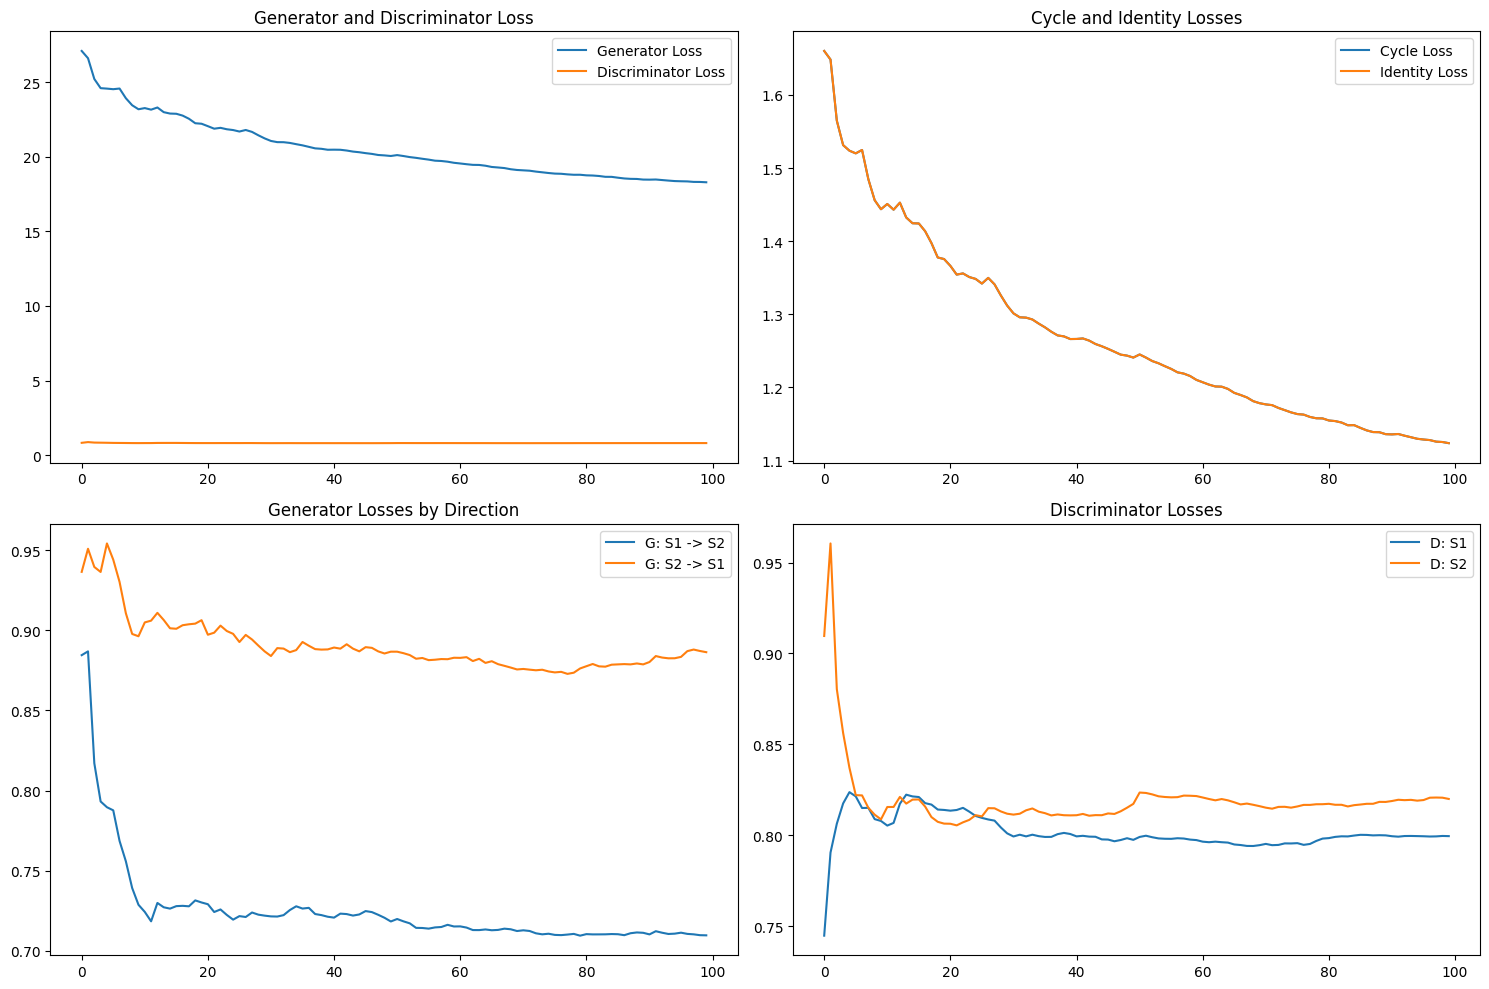

CycleGAN training complete!


In [106]:

def hyperparameter_tuning(data_splits, input_dims, param_grid):
    
    X_train, stage1_train, stage2_train, X_val, stage1_val, stage2_val, _, _, _ = data_splits
    
    # Use a small subset for faster tuning
    subset_size = min(1000, X_train.shape[0])
    idx = np.random.choice(X_train.shape[0], subset_size, replace=False)
    X_subset = X_train[idx]
    stage1_subset = stage1_train[idx]
    stage2_subset = stage2_train[idx]
    
    # Track best parameters and performance
    best_params = None
    best_metrics = None
    best_loss = float('inf')
    
    # Create a directory for tuning results
    os.makedirs('tuning_results', exist_ok=True)
    
    # Simple grid search over parameters
    tuning_results = []
    
    for i, params in enumerate(param_grid):
        print(f"Tuning configuration {i+1}/{len(param_grid)}")
        print(f"Parameters: {params}")
        
        
        model = CycleGAN(
            input_dims=input_dims,
            stage1_dims=stage1_train.shape[1],
            stage2_dims=stage2_train.shape[1],
            **params
        )
        
        
        model.train(
            input_features=X_subset,
            stage1_measurements=stage1_subset,
            stage2_measurements=stage2_subset,
            epochs=20,  #
            batch_size=64,
            validate_every=5,
            sample_interval=10,
            save_model_interval=999,  # Don't save during tuning
            validation_data=(X_val, stage1_val, stage2_val)
        )
        
        # Evaluate on validation set
        metrics = model.evaluate_model(X_val, stage1_val, stage2_val)
        
        # Save this configuration and its results
        result = {
            'params': params,
            'metrics': metrics,
            'total_loss': metrics['stage1_mae'] + metrics['stage2_mae'] + 0.5 * metrics['cycle_s1_mae'] + 0.5 * metrics['cycle_s2_mae']
        }
        tuning_results.append(result)
        
        # Check if this is the best configuration
        if result['total_loss'] < best_loss:
            best_loss = result['total_loss']
            best_params = params
            best_metrics = metrics
            
        # Save intermediate results
        with open(f'tuning_results/tuning_results_{i}.json', 'w') as f:
            json.dump(result, f)
    
    # Save all tuning results
    with open('tuning_results/all_tuning_results.json', 'w') as f:
        json.dump(tuning_results, f)
        
    print("Hyperparameter tuning complete")
    print(f"Best parameters: {best_params}")
    print(f"Best metrics: {best_metrics}")
    
    return best_params, best_metrics

if __name__ == "__main__":
    # Load and prepare data
    data_splits_with_scalers = load_and_prepare_data()
    data_splits = data_splits_with_scalers[:-1]  # Extract just the data splits
    scalers = data_splits_with_scalers[-1]      
    
    # Get input dimensions
    input_dims = data_splits[0].shape[1]
    
    # Train the model with default hyperparameters
    print("Training CycleGAN with default hyperparameters...")
    model = train_cyclegan(data_splits, input_dims)
    
    
    print("Starting hyperparameter tuning...")
    param_grid = [
        {
            'gen_hidden_layers': [256, 128, 64],
            'disc_hidden_layers': [64, 32, 16],
            'gen_dropout_rate': 0.2,
            'disc_dropout_rate': 0.3,
            'gen_learning_rate': 0.0002,
            'disc_learning_rate': 0.0002,
            'lambda_cycle': 10.0,
            'lambda_identity': 1.0
        },
        {
            'gen_hidden_layers': [512, 256, 128],
            'disc_hidden_layers': [128, 64, 32],
            'gen_dropout_rate': 0.3,
            'disc_dropout_rate': 0.4,
            'gen_learning_rate': 0.0001,
            'disc_learning_rate': 0.0001,
            'lambda_cycle': 15.0,
            'lambda_identity': 0.5
        },
        {
            'gen_hidden_layers': [128, 64],
            'disc_hidden_layers': [32, 16],
            'gen_dropout_rate': 0.1,
            'disc_dropout_rate': 0.2,
            'gen_learning_rate': 0.0005,
            'disc_learning_rate': 0.0005,
            'lambda_cycle': 5.0,
            'lambda_identity': 2.0
        }
    ]
    
    best_params, best_metrics = hyperparameter_tuning(data_splits, input_dims, param_grid)
    
    # Train 
    print("Training final model with best hyperparameters...")
    model = train_cyclegan(data_splits, input_dims, best_params)
    
    print("CycleGAN training complete!") 

In [109]:
print("Best hyperparameters:")
print(best_params)



Best hyperparameters:
{'gen_hidden_layers': [512, 256, 128], 'disc_hidden_layers': [128, 64, 32], 'gen_dropout_rate': 0.3, 'disc_dropout_rate': 0.4, 'gen_learning_rate': 0.0001, 'disc_learning_rate': 0.0001, 'lambda_cycle': 15.0, 'lambda_identity': 0.5}


# Conclusion


The project aimed to predict the outcomes in a multi-stage manufacturing process using two different deep learning approaches:

1. LSTM Model - A sequence-based approach using Long Short-Term Memory networks

2. CycleGAN Model - A generative adversarial network approach focusing on bidirectional mapping between manufacturing stages

### LSTM Method
*Test Loss (MSE): 0.0375
*Test MAE: 0.0881

These are relatively low error metrics I think, suggesting good performance. The loss decreased steadily during training. The model converged well, with validation loss stabilizing around 0.03. The early stopping mechanism likely prevented overfitting... At least that was the intention! 

Prediction Accuracy: The MAE of 0.0881 indicates that, on average, predictions were within about 8.8% of the actual values (assuming normalized data), which is quite good for manufacturing process prediction.

Training Efficiency: The model converged relatively quickly (within 20 epochs), suggesting efficient learning.

Generalization: The small gap between training and validation loss indicates good generalization to unseen data.

However if you then take a look at RMSE it paints a different picture. Some features had excellent prediction accuracy (e.g., Stage 1 Measurement 12: RMSE = 0.0855). Others had much higher error rates (e.g., Stage 1 Measurement 1: RMSE = 11.7131). Stage 2 Measurement 9 had the highest RMSE at 14.7440

### CycleGAN Method

Latest Performance Metrics:
* Stage 1 MAE: 0.2323 (Original scale: 0.8207)
* Stage 2 MAE: 0.2547 (Original scale: 1.0449)
* Stage 1 MSE: 0.2223 (Original scale: 4.2356)
* Stage 2 MSE: 0.2698 (Original scale: 11.1760)
* Cycle Consistency MAE:
  * Stage 1: 0.2225
  * Stage 2: 0.2563

The CycleGAN approach showed good bidirectional mapping between stages with consistent performance across both manufacturing stages. (Slightly better performance on Stage 2 predictions). This is really valuable for understanding stage relationships. This highlights the need for a very clear understanding and definition between the processes. 

### Overall, 
I believe that this is an extremely convincing foray into deep learning and additive manufacturing. I believe that it shows very great strengths, both beign analyzed in time sseries by LSTM, but also with being analyzed by CycleGAN, learning what a perfect example is and spotting errors ahead of time. CycleGAN had more consistent performance, however LSTM was computationally less strenuous. Also, the time sequence dependency really highlights the potential for a better model with more advanced hypertuning. Both ways, clearly seperating and handling the two stages and examining their relationships is key. I believe furthe statistical analysis would be key for finding the best way to account for this. 

For practical applications, employing both models would bring the most benifits. 

1. Using the LSTM model for general prediction tasks where overall accuracy is key

2. Using the CycleGAN model when you need to understand how changes in one stage affect the other or when consistent predictions across all measurements are more important than having extremely accurate predictions for some measurements but poor ones for others

# References

Melt Down long Data sets for plottong
https://dotnetfiddle.net/Rmlhy0

Keras Deep LEarning Examples (Provided by Instructor)
https://keras.io/examples/

KEras Tutorial
https://github.com/kashif/tf-keras-tutorial/blob/tf2/1-fashion-mnist-with-keras.ipynb

Presentation
https://prezi.com/p/edit/rdrmtrfydsb9/


Time Series and Auto Encoders
https://keras.io/examples/timeseries/timeseries_anomaly_detection/


